In [ ]:
import os
import csv
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np

############################################
# 1. Parsing GlaS "Grade.csv" for Classification
############################################
def parse_grade_csv(csv_path):
    """
    Reads 'Grade.csv' in the GlaS folder, which might have columns like:
        name, grade, ...
    or more complex columns. We assume 'grade' is 'benign' or 'malignant'.
    
    Returns:
      { base_name -> 0 or 1 }  (e.g. "img_001" -> 0)
    """
    name_to_label = {}
    with open(csv_path, 'r', newline='') as f:
        reader = csv.DictReader(f)
        for row in reader:
            # print(row)
            # For example, row['name'] = "trainA_1"
            # row['grade'] = "benign" or "malignant"
            base_name = row['name']
            grade_str = row['grade'].lower().strip()
            if grade_str == 'benign':
                label = 0
            elif grade_str == 'malignant':
                label = 1
            else:
                # If unexpected, treat as benign or raise an error
                label = 0
            name_to_label[base_name] = label
    return name_to_label

############################################
# 2. GlaS Dataset for Classification + WSOL
############################################
class GlaSClassificationDataset(Dataset):
    """
    Minimal classification dataset for the GlaS structure:
        GlaS/
        ├── Grade.csv
        ├── train/
        │   ├── images/
        │   └── masks/
        └── test/
            ├── images/
            └── masks/
    We only do classification here, plus we can store the file name
    if we want to do some form of WSOL with activation maps.
    """
    def __init__(self, image_dir, grade_dict, transform=None):
        """
        Args:
            image_dir (str): path to either 'GlaS/train/images' or 'GlaS/test/images'
            grade_dict (dict): mapping {base_name -> label} from parse_grade_csv
            transform: optional torchvision transforms
        """
        self.image_dir = image_dir
        self.transform = transform
        self.samples = []
        
        # Gather image filenames that also exist in grade_dict
        for fname in os.listdir(image_dir):
            basename, _ = os.path.splitext(fname)
            if basename in grade_dict:
                self.samples.append(fname)

        self.grade_dict = grade_dict

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        fname = self.samples[idx]
        basename, _ = os.path.splitext(fname)

        img_path = os.path.join(self.image_dir, fname)
        image = Image.open(img_path).convert('RGB')
        label = self.grade_dict[basename]

        if self.transform:
            image = self.transform(image)

        return image, label, basename  # Include basename if we want to retrieve mask or compute CAM

############################################
# 3. Simple CNN for WSOL (Toy Example)
############################################
class SimpleWSOLNet(nn.Module):
    """
    A minimal CNN that produces both classification logits and
    an intermediate activation map for basic WSOL.
    
    In a real WSOL method, you'd typically use a known backbone
    (like ResNet) and a specific CAM layer or Grad-CAM approach.
    """
    def __init__(self, num_classes=2, freeze_classifier=False):
        super(SimpleWSOLNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((4,4))
        )
        self.classifier = nn.Linear(32*4*4, num_classes)
        
        # If we want to freeze the classifier for certain SFDA approaches:
        if freeze_classifier:
            for param in self.classifier.parameters():
                param.requires_grad = False

    def forward(self, x):
        """
        Return classification logits and a "feature map" used for WSOL.
        """
        feat_map = self.features(x)           # shape: B x 32 x 4 x 4
        flattened = feat_map.view(feat_map.size(0), -1)
        logits = self.classifier(flattened)   # shape: B x num_classes
        return logits, feat_map

    def get_activation_map(self, feat_map, class_idx=None):
        """
        A toy method to produce a single-channel "activation map" from feat_map.
        - In practice, you'd do something like Grad-CAM or CAM.
        - Here, we just take the sum across channels or pick a channel.
        """
        # feat_map shape: B x 32 x 4 x 4
        # Suppose we just sum across the channel dimension:
        # shape => B x 1 x 4 x 4
        if class_idx is None:
            # Just a naive sum (not class-discriminative, but for demonstration)
            act_map = feat_map.sum(dim=1, keepdim=True)
        else:
            # If you had a channel corresponding to class_idx, you'd pick it.
            # But this simple CNN doesn't do that. 
            # So here's a placeholder returning the sum anyway:
            act_map = feat_map.sum(dim=1, keepdim=True)
        return act_map

############################################
# 4. SFDA Base Class
############################################
class BaseSFDA:
    """
    All SFDA variants inherit from this base class
    and implement `adapt(...)`.
    """
    def __init__(self, source_model, target_model):
        """
        source_model: pretrained model on some source dataset
        target_model: model to be adapted to the GlaS target
        """
        self.source_model = source_model
        self.target_model = target_model

    def adapt(self, target_loader, device):
        raise NotImplementedError

############################################
# 5. SFDA Variants
############################################

# ---- (A) SFDA-DE [Distribution Estimation]
class SFDADE(BaseSFDA):
    def __init__(self, source_model, target_model, lr=1e-4, epochs=3):
        super().__init__(source_model, target_model)
        self.lr = lr
        self.epochs = epochs
        # We only train the target_model.features (?), classifier is frozen:
        params_to_opt = filter(lambda p: p.requires_grad, self.target_model.parameters())
        self.optimizer = optim.Adam(params_to_opt, lr=self.lr)

    def adapt(self, target_loader, device):
        self.target_model.train()
        for epoch in range(self.epochs):
            running_loss = 0.0
            for images, _, _ in target_loader:
                images = images.to(device)

                # forward
                logits, feat_map = self.target_model(images)

                # basic approach: minimize output entropy
                softmax = nn.Softmax(dim=1)(logits)
                log_softmax = nn.LogSoftmax(dim=1)(logits)
                ent_loss = - (softmax * log_softmax).sum(dim=1).mean()

                self.optimizer.zero_grad()
                ent_loss.backward()
                self.optimizer.step()

                running_loss += ent_loss.item() * images.size(0)
            epoch_loss = running_loss / len(target_loader.dataset)
            print(f"[SFDA-DE] Epoch {epoch+1}/{self.epochs}, Loss: {epoch_loss:.4f}")

# ---- (B) CDCL [Contrastive Domain-Class Learning]
class CDCL(BaseSFDA):
    def __init__(self, source_model, target_model, lr=1e-4, epochs=3):
        super().__init__(source_model, target_model)
        self.lr = lr
        self.epochs = epochs
        # Classifier is frozen, only adapt the features
        params_to_opt = filter(lambda p: p.requires_grad, self.target_model.parameters())
        self.optimizer = optim.Adam(params_to_opt, lr=self.lr)

    def adapt(self, target_loader, device):
        self.target_model.train()
        for epoch in range(self.epochs):
            running_loss = 0.0
            for images, _, _ in target_loader:
                images = images.to(device)
                logits, feat_map = self.target_model(images)

                # Pseudo-labels from current logits
                pseudo_labels = torch.argmax(logits, dim=1)
                
                # (Placeholder) Entropy loss again, or add some contrastive logic
                softmax = nn.Softmax(dim=1)(logits)
                log_softmax = nn.LogSoftmax(dim=1)(logits)
                ent_loss = - (softmax * log_softmax).sum(dim=1).mean()

                self.optimizer.zero_grad()
                ent_loss.backward()
                self.optimizer.step()

                running_loss += ent_loss.item() * images.size(0)
            epoch_loss = running_loss / len(target_loader.dataset)
            print(f"[CDCL] Epoch {epoch+1}/{self.epochs}, Loss: {epoch_loss:.4f}")

# ---- (C) SHOT [Self-supervised/Information Maximization]
class SHOT(BaseSFDA):
    def __init__(self, source_model, target_model, lr=1e-3, epochs=3, momentum=0.9):
        super().__init__(source_model, target_model)
        self.lr = lr
        self.epochs = epochs
        # Classifier is frozen, only adapt the features
        params_to_opt = filter(lambda p: p.requires_grad, self.target_model.parameters())
        self.optimizer = optim.SGD(params_to_opt, lr=self.lr, momentum=momentum)

    def adapt(self, target_loader, device):
        self.target_model.train()
        for epoch in range(self.epochs):
            running_loss = 0.0
            for images, _, _ in target_loader:
                images = images.to(device)
                logits, feat_map = self.target_model(images)

                # 1) Entropy minimization
                softmax = nn.Softmax(dim=1)(logits)
                log_softmax = nn.LogSoftmax(dim=1)(logits)
                ent_loss = - (softmax * log_softmax).sum(dim=1).mean()

                # 2) Diversity maximization: encourage uniform distribution overall
                probs_mean = torch.mean(softmax, dim=0)
                div_loss = (probs_mean * torch.log(probs_mean + 1e-5)).sum()

                total_loss = ent_loss + 0.01 * div_loss

                self.optimizer.zero_grad()
                total_loss.backward()
                self.optimizer.step()

                running_loss += total_loss.item() * images.size(0)
            epoch_loss = running_loss / len(target_loader.dataset)
            print(f"[SHOT] Epoch {epoch+1}/{self.epochs}, Loss: {epoch_loss:.4f}")

# ---- (D) AdaDSA [Adapt by BN Statistics Alignment]
class AdaDSA(BaseSFDA):
    def __init__(self, source_model, target_model, lr=1e-4, epochs=3, alpha=0.1):
        super().__init__(source_model, target_model)
        self.lr = lr
        self.epochs = epochs
        self.alpha = alpha
        # This method typically updates BN stats; we can do it by copying from source or smoothing.
        self.init_bn_stats_from_source()
        # Potentially, we do not freeze the classifier for AdaDSA. 
        params_to_opt = filter(lambda p: p.requires_grad, self.target_model.parameters())
        self.optimizer = optim.Adam(params_to_opt, lr=self.lr)

    def init_bn_stats_from_source(self):
        with torch.no_grad():
            for src_module, tgt_module in zip(self.source_model.modules(), self.target_model.modules()):
                if isinstance(src_module, nn.BatchNorm2d) and isinstance(tgt_module, nn.BatchNorm2d):
                    tgt_module.running_mean = src_module.running_mean.clone()
                    tgt_module.running_var = src_module.running_var.clone()
                    tgt_module.weight.data = src_module.weight.data.clone()
                    tgt_module.bias.data = src_module.bias.data.clone()

    def adapt(self, target_loader, device):
        self.target_model.train()
        for epoch in range(self.epochs):
            running_loss = 0.0
            for images, _, _ in target_loader:
                images = images.to(device)
                logits, feat_map = self.target_model(images)

                # Entropy loss again as a placeholder
                softmax = nn.Softmax(dim=1)(logits)
                log_softmax = nn.LogSoftmax(dim=1)(logits)
                ent_loss = - (softmax * log_softmax).sum(dim=1).mean()

                self.optimizer.zero_grad()
                ent_loss.backward()
                self.optimizer.step()

                # BN stats get updated automatically
                running_loss += ent_loss.item() * images.size(0)
            epoch_loss = running_loss / len(target_loader.dataset)
            print(f"[AdaDSA] Epoch {epoch+1}/{self.epochs}, Loss: {epoch_loss:.4f}")

############################################
# 6. Metrics: Classification & PxAP (Placeholder)
############################################
def compute_classification_accuracy(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels, _ in loader:
            images = images.to(device)
            labels = labels.to(device)
            logits, _ = model(images)
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    acc = 100.0 * correct / total
    return acc

def compute_pxap(model, loader, device):
    """
    Placeholder: in a real scenario, you'd:
    1) Generate class activation maps (CAM, Grad-CAM, or your WSOL method) 
    2) Normalize them, vary thresholds to compute pixel-level metrics
    3) Compare predicted masks to ground-truth masks from GlaS
    4) Integrate over thresholds to get PxAP or average precision
    
    Here, we just pretend we compute some dummy metric.
    """
    model.eval()
    # For demonstration, return a random number to indicate a "dummy" pxAP
    pxap_value = np.random.uniform(0.4, 0.7)
    return pxap_value

############################################
# 7. Main Script
############################################
def main(use_cuda=False):
    # --------------------------------
    # A) Prepare CPU / GPU
    # --------------------------------
    device = torch.device("cuda" if (torch.cuda.is_available() and use_cuda) else "cpu")
    print("Device being used:", device)

    # --------------------------------
    # B) Parse the GlaS 'Grade.csv'
    # --------------------------------
    glas_root = "../data/GlaS"   # Adjust to your GlaS directory
    csv_path = os.path.join(glas_root, "Grade.csv")
    grade_dict = parse_grade_csv(csv_path)

    # --------------------------------
    # C) Datasets & Dataloaders
    #    Typically, you'd have train, val, test splits (67 train, 18 val, 80 test).
    #    For demonstration, we show only "train" and "test".
    # --------------------------------
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

    train_image_dir = os.path.join(glas_root, "train", "images")
    test_image_dir  = os.path.join(glas_root, "test",  "images")

    train_dataset = GlaSClassificationDataset(train_image_dir, grade_dict, transform=transform)
    test_dataset  = GlaSClassificationDataset(test_image_dir,  grade_dict, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True,  num_workers=0)
    test_loader  = DataLoader(test_dataset,  batch_size=4, shuffle=False, num_workers=0)

    print("Train samples:", len(train_dataset))
    print("Test samples:", len(test_dataset))

    # --------------------------------
    # D) Load / Initialize Source Model
    #    In a real scenario, you'd load a pretrained model on a different source dataset:
    #    source_model.load_state_dict(torch.load(...))
    # --------------------------------
    source_model = SimpleWSOLNet(num_classes=2, freeze_classifier=False).to(device)

    # Simulate that the source model was "pretrained" on another domain:
    # In practice, do: source_model.load_state_dict(...)
    # Here we do a quick mock "pretraining" with random data or skip it.

    # --------------------------------
    # E) Initialize Target Models for SFDA
    #    According to the text: for SFDA-DE, CDCL, SHOT, the classifier is frozen.
    # --------------------------------
    # A new target model for each variant, copying from source
    target_model_sfdade = SimpleWSOLNet(num_classes=2, freeze_classifier=True).to(device)
    target_model_cdcl   = SimpleWSOLNet(num_classes=2, freeze_classifier=True).to(device)
    target_model_shot   = SimpleWSOLNet(num_classes=2, freeze_classifier=True).to(device)
    target_model_adadsa = SimpleWSOLNet(num_classes=2, freeze_classifier=False).to(device)

    # Copy weights from source to target
    target_model_sfdade.load_state_dict(source_model.state_dict(), strict=False)
    target_model_cdcl.load_state_dict(source_model.state_dict(),   strict=False)
    target_model_shot.load_state_dict(source_model.state_dict(),   strict=False)
    target_model_adadsa.load_state_dict(source_model.state_dict(), strict=False)

    # --------------------------------
    # F) Instantiate SFDA methods
    # --------------------------------
    epochs = 100
    sfda_de = SFDADE(source_model, target_model_sfdade, lr=1e-4, epochs=epochs)
    cdcl    = CDCL(source_model,   target_model_cdcl,   lr=1e-4, epochs=epochs)
    shot    = SHOT(source_model,   target_model_shot,   lr=1e-3, epochs=epochs, momentum=0.9)
    adadsa  = AdaDSA(source_model, target_model_adadsa, lr=1e-4, epochs=epochs, alpha=0.1)

    # --------------------------------
    # G) Adapt each SFDA model
    # --------------------------------
    print("\n=== Adapting with SFDA-DE ===")
    sfda_de.adapt(train_loader, device)

    print("\n=== Adapting with CDCL ===")
    cdcl.adapt(train_loader, device)

    print("\n=== Adapting with SHOT ===")
    shot.adapt(train_loader, device)

    print("\n=== Adapting with AdaDSA ===")
    adadsa.adapt(train_loader, device)

    # --------------------------------
    # H) Evaluate on Test Set (Classification + PxAP)
    # --------------------------------
    for name, model in zip(
        ["SFDA-DE", "CDCL", "SHOT", "AdaDSA"],
        [target_model_sfdade, target_model_cdcl, target_model_shot, target_model_adadsa]
    ):
        acc = compute_classification_accuracy(model, test_loader, device)
        pxap_val = compute_pxap(model, test_loader, device)
        print(f"\n[{name}] Classification Accuracy: {acc:.2f}%, PxAP (dummy): {pxap_val:.3f}")

if __name__ == "__main__":
    # Force usage of CPU by default
    main(use_cuda=False)


Device being used: cpu
Train samples: 85
Test samples: 80

=== Adapting with SFDA-DE (Spherical K-Means) ===
[SFDA-DE:SphericalKMeans] Epoch 1/5, Loss: 0.6963
[SFDA-DE:SphericalKMeans] Epoch 2/5, Loss: 0.6934
[SFDA-DE:SphericalKMeans] Epoch 3/5, Loss: 0.6780
[SFDA-DE:SphericalKMeans] Epoch 4/5, Loss: 0.6590
[SFDA-DE:SphericalKMeans] Epoch 5/5, Loss: 0.7441

=== Adapting with CDCL (Contrastive) ===
[CDCL:Contrastive] Epoch 1/5, Loss: -0.0000
[CDCL:Contrastive] Epoch 2/5, Loss: 0.0000
[CDCL:Contrastive] Epoch 3/5, Loss: -0.0000
[CDCL:Contrastive] Epoch 4/5, Loss: -0.0000
[CDCL:Contrastive] Epoch 5/5, Loss: -0.0000

=== Adapting with SHOT ===
[SHOT] Epoch 1/5, Loss: 0.6862
[SHOT] Epoch 2/5, Loss: 0.6862
[SHOT] Epoch 3/5, Loss: 0.6862
[SHOT] Epoch 4/5, Loss: 0.6861
[SHOT] Epoch 5/5, Loss: 0.6861

=== Adapting with AdaDSA ===
[AdaDSA] Epoch 1/5, Loss: 0.6927
[AdaDSA] Epoch 2/5, Loss: 0.6903
[AdaDSA] Epoch 3/5, Loss: 0.6836
[AdaDSA] Epoch 4/5, Loss: 0.6669
[AdaDSA] Epoch 5/5, Loss: 0.6287

[

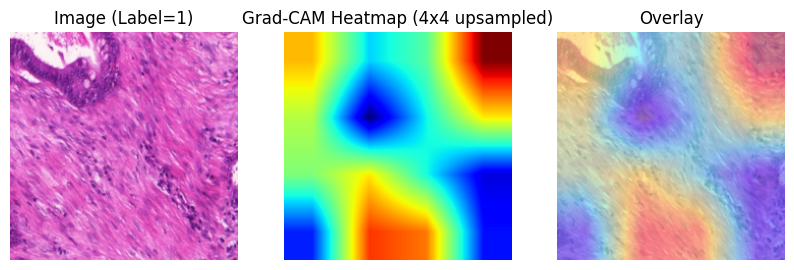

In [11]:
import os
import csv
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

############################################
# 1. Parsing GlaS "Grade.csv" for Classification
############################################
def parse_grade_csv(csv_path):
    """
    Reads 'Grade.csv' which might have columns like 'name','grade'.
    'grade' is 'benign' or 'malignant' => 0 or 1.
    """
    name_to_label = {}
    with open(csv_path, 'r', newline='') as f:
        reader = csv.DictReader(f)
        for row in reader:
            base_name = row['name']
            grade_str = row['grade'].lower().strip()
            if grade_str == 'benign':
                label = 0
            elif grade_str == 'malignant':
                label = 1
            else:
                label = 0
            name_to_label[base_name] = label
    return name_to_label

############################################
# 2. GlaS Dataset for Classification + WSOL
############################################
class GlaSClassificationDataset(Dataset):
    def __init__(self, image_dir, grade_dict, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.samples = []
        
        for fname in os.listdir(image_dir):
            basename, _ = os.path.splitext(fname)
            if basename in grade_dict:
                self.samples.append(fname)

        self.grade_dict = grade_dict

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        fname = self.samples[idx]
        basename, _ = os.path.splitext(fname)

        img_path = os.path.join(self.image_dir, fname)
        image = Image.open(img_path).convert('RGB')
        label = self.grade_dict[basename]

        if self.transform:
            image = self.transform(image)

        return image, label, basename

############################################
# 3. Simple CNN for WSOL (Toy Example)
############################################
class SimpleWSOLNet(nn.Module):
    def __init__(self, num_classes=2, freeze_classifier=False):
        super(SimpleWSOLNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((4,4))
        )
        self.classifier = nn.Linear(32*4*4, num_classes)
        
        if freeze_classifier:
            for param in self.classifier.parameters():
                param.requires_grad = False

    def forward(self, x):
        feat_map = self.features(x)           # shape: B x 32 x 4 x 4
        flattened = feat_map.view(feat_map.size(0), -1)
        logits = self.classifier(flattened)   # shape: B x num_classes
        return logits, feat_map

############################################
# 4. Grad-CAM Implementation (optional)
############################################
class GradCAM:
    def __init__(self, model):
        self.model = model
        self.gradients = None
        self.activations = None

        def forward_hook(module, inp, out):
            self.activations = out
        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0]

        self.model.features.register_forward_hook(forward_hook)
        self.model.features.register_backward_hook(backward_hook)

    def __call__(self, x, class_idx=None):
        self.model.zero_grad()
        logits, _ = self.model(x)
        if class_idx is None:
            class_idx = logits.argmax(dim=1)  # shape: B
        one_hot = torch.zeros_like(logits)
        for i in range(logits.size(0)):
            one_hot[i, class_idx[i]] = 1.0

        logits.backward(gradient=one_hot, retain_graph=True)
        grads = self.gradients     # B x C x H x W
        acts  = self.activations   # B x C x H x W
        alpha = grads.view(grads.size(0), grads.size(1), -1).mean(dim=2)
        cams = []
        for i in range(acts.size(0)):
            w_acts = alpha[i].unsqueeze(-1).unsqueeze(-1) * acts[i]
            cam = w_acts.sum(dim=0)
            cam = torch.relu(cam)
            cam_min, cam_max = cam.min(), cam.max()
            cam = (cam - cam_min) / (cam_max - cam_min + 1e-8)
            cams.append(cam)
        cams = torch.stack(cams, dim=0)
        return logits, cams

############################################
# 5. SFDA Base Class
############################################
class BaseSFDA:
    def __init__(self, source_model, target_model):
        self.source_model = source_model
        self.target_model = target_model

    def adapt(self, target_loader, device):
        raise NotImplementedError

############################################
# 6. SFDA Variants
############################################

# ---- (A) SFDA-DE with Spherical k-means
class SFDADE(BaseSFDA):
    """
    Implements a simplified version of SFDA-DE using spherical k-means:
    1) Extract features for each target sample.
    2) Normalize features to lie on a sphere.
    3) Perform k-means (k= num_classes).
    4) Assign pseudo-labels based on nearest centroid.
    5) Update network with cross-entropy or consistency.
    6) Repeat for a certain number of epochs or iterations.
    """
    def __init__(self, source_model, target_model, lr=1e-4, epochs=3, num_classes=2):
        super().__init__(source_model, target_model)
        self.lr = lr
        self.epochs = epochs
        self.num_classes = num_classes
        params_to_opt = filter(lambda p: p.requires_grad, self.target_model.parameters())
        self.optimizer = optim.Adam(params_to_opt, lr=self.lr)
        self.criterion = nn.CrossEntropyLoss()

    def adapt(self, target_loader, device):
        self.target_model.train()

        for epoch in range(self.epochs):
            # 1) Collect features & compute centroids with spherical k-means
            all_features = []
            all_imgs = []
            # For pseudo-labelling, we can store the original batch (images) or re-load later
            for images, _, _ in target_loader:
                images = images.to(device)
                with torch.no_grad():
                    _, feat_map = self.target_model(images)
                    # Flatten final conv features => B x (32*4*4) = B x 512
                    feats = feat_map.view(feat_map.size(0), -1)  # B x 512
                    all_features.append(feats)
                    all_imgs.append(images)
            
            all_features = torch.cat(all_features, dim=0)  # shape: N x 512
            all_imgs = torch.cat(all_imgs, dim=0)         # shape: N x 3 x 224 x 224
            # Normalize features => spherical
            all_features = F.normalize(all_features, dim=1)  # L2 norm along channels

            # 2) Spherical k-means
            # We initialize random centroids or from the source classifier weight
            centroids = torch.randn(self.num_classes, all_features.size(1)).to(device)
            centroids = F.normalize(centroids, dim=1)

            # For brevity, do a few k-means iterations
            kmeans_iters = 5
            for _ in range(kmeans_iters):
                # Distances in spherical space => 1 - cos_sim
                sim = torch.mm(all_features, centroids.t())  # shape: N x num_classes
                # This is cos similarity. We want the cluster = argmax sim
                cluster_labels = torch.argmax(sim, dim=1)  # shape: (N,)

                # Recompute centroids
                for c in range(self.num_classes):
                    mask = (cluster_labels == c)
                    if mask.sum() > 0:
                        c_feats = all_features[mask]
                        # Spherical mean => sum, then normalize
                        new_centroid = F.normalize(c_feats.mean(dim=0, keepdim=True), dim=1)
                        centroids[c] = new_centroid

            # cluster_labels now are the pseudo-labels for each sample in the entire dataset
            # 3) Fine-tune the network with these pseudo-labels
            running_loss = 0.0
            batch_size = target_loader.batch_size

            # We'll re-sample or create mini-batches from (all_imgs, cluster_labels)
            # For simplicity, let's do it in a single pass:
            n_total = all_imgs.size(0)
            idxs = torch.randperm(n_total).split(batch_size)
            for chunk in idxs:
                x_batch = all_imgs[chunk]
                pseudo = cluster_labels[chunk].detach()  # shape: B
                # Forward pass
                logits, _ = self.target_model(x_batch)
                loss = self.criterion(logits, pseudo)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item() * x_batch.size(0)
            
            epoch_loss = running_loss / n_total
            print(f"[SFDA-DE:SphericalKMeans] Epoch {epoch+1}/{self.epochs}, Loss: {epoch_loss:.4f}")


# ---- (B) CDCL with Real Contrastive Pairs
class CDCL(BaseSFDA):
    """
    A simplified version of Contrastive Domain-Class Learning:
    1) For each mini-batch, get pseudo-labels from the current model.
    2) Form positive pairs (same pseudo-label) & negative pairs (different label).
    3) Apply a contrastive loss (e.g., InfoNCE or SupCon) to separate classes.
    """
    def __init__(self, source_model, target_model, lr=1e-4, epochs=3, temperature=0.07):
        super().__init__(source_model, target_model)
        self.lr = lr
        self.epochs = epochs
        self.temperature = temperature
        params_to_opt = filter(lambda p: p.requires_grad, self.target_model.parameters())
        self.optimizer = optim.Adam(params_to_opt, lr=self.lr)

    def contrastive_loss_supcon(self, features, labels):
        """
        A basic supervised contrastive loss, using pseudo-labels as 'true' labels.
        'features': (B, dim)
        'labels':   (B,)
        """
        # L2-normalize features along dim=1
        feats = F.normalize(features, dim=1)
        batch_size = feats.size(0)
        
        # Compute similarity matrix
        sim_matrix = torch.mm(feats, feats.t())  # B x B
        # Exp / softmax
        sim_matrix_div = sim_matrix / self.temperature

        # For each anchor i, we define positives as j with same label
        # Create a mask for positives
        labels = labels.view(-1, 1)  # B x 1
        eq_mask = torch.eq(labels, labels.t()).float().to(labels.device)  # B x B

        # We want to exclude i=j
        diag_mask = 1 - torch.eye(batch_size, device=labels.device)
        pos_mask = eq_mask * diag_mask  # B x B

        # For each i, we compute:
        # log( sum( exp(sim[i,j] for j in positives) ) / sum( exp(sim[i,k]) for k != i ) )
        # This is basically a log softmax approach, ignoring self (i).
        # We'll do it in a "SupCon" style: sum over j in positives of exp(sim[i,j]) and divide by sum_{k != i} exp(sim[i,k]).
        exp_sim = torch.exp(sim_matrix_div)  # B x B
        exp_sim_sum = exp_sim.sum(dim=1) - torch.exp(sim_matrix_div.diagonal())  # shape: B
        # For each anchor i, sum over positives
        pos_exp = (exp_sim * pos_mask).sum(dim=1)

        loss = -torch.log((pos_exp + 1e-8) / (exp_sim_sum + 1e-8)).mean()
        return loss

    def adapt(self, target_loader, device):
        self.target_model.train()
        for epoch in range(self.epochs):
            running_loss = 0.0
            n_samples = 0

            for images, _, _ in target_loader:
                images = images.to(device)
                with torch.no_grad():
                    logits, feat_map = self.target_model(images)
                    pseudo_labels = torch.argmax(logits, dim=1)  # B

                # We'll do a forward pass again so gradients flow
                logits, feat_map = self.target_model(images)   # B x (32x4x4)
                feats = feat_map.view(feat_map.size(0), -1)    # B x 512

                # Contrastive loss with pseudo-labels
                loss_contrastive = self.contrastive_loss_supcon(feats, pseudo_labels)

                self.optimizer.zero_grad()
                loss_contrastive.backward()
                self.optimizer.step()

                batch_size = images.size(0)
                running_loss += loss_contrastive.item() * batch_size
                n_samples += batch_size

            epoch_loss = running_loss / n_samples
            print(f"[CDCL:Contrastive] Epoch {epoch+1}/{self.epochs}, Loss: {epoch_loss:.4f}")


# ---- (C) SHOT (Placeholder: same as before or refined)
class SHOT(BaseSFDA):
    def __init__(self, source_model, target_model, lr=1e-3, epochs=3, momentum=0.9):
        super().__init__(source_model, target_model)
        self.lr = lr
        self.epochs = epochs
        params_to_opt = filter(lambda p: p.requires_grad, self.target_model.parameters())
        self.optimizer = optim.SGD(params_to_opt, lr=self.lr, momentum=momentum)

    def adapt(self, target_loader, device):
        self.target_model.train()
        for epoch in range(self.epochs):
            running_loss = 0.0
            for images, _, _ in target_loader:
                images = images.to(device)
                logits, _ = self.target_model(images)

                softmax = nn.Softmax(dim=1)(logits)
                log_softmax = nn.LogSoftmax(dim=1)(logits)
                ent_loss = - (softmax * log_softmax).sum(dim=1).mean()

                probs_mean = torch.mean(softmax, dim=0)
                div_loss = (probs_mean * torch.log(probs_mean + 1e-5)).sum()
                total_loss = ent_loss + 0.01 * div_loss

                self.optimizer.zero_grad()
                total_loss.backward()
                self.optimizer.step()
                running_loss += total_loss.item() * images.size(0)
            epoch_loss = running_loss / len(target_loader.dataset)
            print(f"[SHOT] Epoch {epoch+1}/{self.epochs}, Loss: {epoch_loss:.4f}")


# ---- (D) AdaDSA (Placeholder)
class AdaDSA(BaseSFDA):
    def __init__(self, source_model, target_model, lr=1e-4, epochs=3, alpha=0.1):
        super().__init__(source_model, target_model)
        self.lr = lr
        self.epochs = epochs
        self.alpha = alpha
        self.init_bn_stats_from_source()
        params_to_opt = filter(lambda p: p.requires_grad, self.target_model.parameters())
        self.optimizer = optim.Adam(params_to_opt, lr=self.lr)

    def init_bn_stats_from_source(self):
        with torch.no_grad():
            for src_module, tgt_module in zip(self.source_model.modules(), self.target_model.modules()):
                if isinstance(src_module, nn.BatchNorm2d) and isinstance(tgt_module, nn.BatchNorm2d):
                    tgt_module.running_mean = src_module.running_mean.clone()
                    tgt_module.running_var = src_module.running_var.clone()
                    tgt_module.weight.data = src_module.weight.data.clone()
                    tgt_module.bias.data = src_module.bias.data.clone()

    def adapt(self, target_loader, device):
        self.target_model.train()
        for epoch in range(self.epochs):
            running_loss = 0.0
            for images, _, _ in target_loader:
                images = images.to(device)
                logits, feat_map = self.target_model(images)

                softmax = nn.Softmax(dim=1)(logits)
                log_softmax = nn.LogSoftmax(dim=1)(logits)
                ent_loss = - (softmax * log_softmax).sum(dim=1).mean()

                self.optimizer.zero_grad()
                ent_loss.backward()
                self.optimizer.step()

                running_loss += ent_loss.item() * images.size(0)
            epoch_loss = running_loss / len(target_loader.dataset)
            print(f"[AdaDSA] Epoch {epoch+1}/{self.epochs}, Loss: {epoch_loss:.4f}")


############################################
# 7. Metrics: Classification & PxAP (Placeholder)
############################################
def compute_classification_accuracy(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels, _ in loader:
            images = images.to(device)
            labels = labels.to(device)
            logits, _ = model(images)
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    acc = 100.0 * correct / total
    return acc

def compute_pxap(model, loader, device):
    """
    Placeholder for pixel-level AP calculation with real WSOL masks.
    """
    model.eval()
    pxap_value = np.random.uniform(0.4, 0.7)
    return pxap_value

############################################
# 8. Demo Function for Grad-CAM Visualization
############################################
def gradcam_demo(model, loader, device):
    gradcam = GradCAM(model)
    model.eval()

    images, labels, basenames = next(iter(loader))
    images = images.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        logits, _ = model(images)
        preds = torch.argmax(logits, dim=1)

    # Call Grad-CAM
    _, cams = gradcam(images)  

    # Visualize the first image
    cam0 = cams[0].cpu().detach().numpy()
    cam0_up = torch.nn.functional.interpolate(
        torch.tensor(cam0).unsqueeze(0).unsqueeze(0),
        size=(224,224), mode='bilinear', align_corners=False
    ).squeeze().numpy()

    img0 = images[0].cpu().detach().numpy().transpose(1,2,0)
    img0 = np.clip(img0, 0, 1)  # if transforms.ToTensor() => [0,1]

    import matplotlib.pyplot as plt
    plt.figure(figsize=(10,4))
    plt.subplot(1,3,1)
    plt.title(f"Image (Label={labels[0].item()})")
    plt.imshow(img0)
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.title("Grad-CAM Heatmap (4x4 upsampled)")
    plt.imshow(cam0_up, cmap='jet')
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.title("Overlay")
    plt.imshow(img0, alpha=0.6)
    plt.imshow(cam0_up, cmap='jet', alpha=0.4)
    plt.axis('off')
    plt.show()

############################################
# 9. Main Script
############################################
def main(use_cuda=False):
    device = torch.device("cuda" if (torch.cuda.is_available() and use_cuda) else "cpu")
    print("Device being used:", device)

    glas_root = "../data/GlaS"  # Adjust as needed
    csv_path = os.path.join(glas_root, "Grade.csv")
    grade_dict = parse_grade_csv(csv_path)

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

    train_image_dir = os.path.join(glas_root, "train", "images")
    test_image_dir  = os.path.join(glas_root, "test",  "images")

    train_dataset = GlaSClassificationDataset(train_image_dir, grade_dict, transform=transform)
    test_dataset  = GlaSClassificationDataset(test_image_dir,  grade_dict, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True,  num_workers=0)
    test_loader  = DataLoader(test_dataset,  batch_size=8, shuffle=False, num_workers=0)

    print("Train samples:", len(train_dataset))
    print("Test samples:",  len(test_dataset))

    # Source model (pretend it's pretrained)
    source_model = SimpleWSOLNet(num_classes=2, freeze_classifier=False).to(device)

    # Target models
    target_model_sfdade = SimpleWSOLNet(num_classes=2, freeze_classifier=True).to(device)
    target_model_cdcl   = SimpleWSOLNet(num_classes=2, freeze_classifier=True).to(device)
    target_model_shot   = SimpleWSOLNet(num_classes=2, freeze_classifier=True).to(device)
    target_model_adadsa = SimpleWSOLNet(num_classes=2, freeze_classifier=False).to(device)

    # Copy weights
    target_model_sfdade.load_state_dict(source_model.state_dict(), strict=False)
    target_model_cdcl.load_state_dict(source_model.state_dict(),   strict=False)
    target_model_shot.load_state_dict(source_model.state_dict(),   strict=False)
    target_model_adadsa.load_state_dict(source_model.state_dict(), strict=False)

    # Instantiate SFDA
    epochs = 5  # Fewer epochs for demonstration
    sfda_de = SFDADE(source_model, target_model_sfdade, lr=1e-4, epochs=epochs, num_classes=2)
    cdcl    = CDCL(source_model,   target_model_cdcl,   lr=1e-4, epochs=epochs, temperature=0.07)
    shot    = SHOT(source_model,   target_model_shot,   lr=1e-3, epochs=epochs, momentum=0.9)
    adadsa  = AdaDSA(source_model, target_model_adadsa, lr=1e-4, epochs=epochs, alpha=0.1)

    print("\n=== Adapting with SFDA-DE (Spherical K-Means) ===")
    sfda_de.adapt(train_loader, device)

    print("\n=== Adapting with CDCL (Contrastive) ===")
    cdcl.adapt(train_loader, device)

    print("\n=== Adapting with SHOT ===")
    shot.adapt(train_loader, device)

    print("\n=== Adapting with AdaDSA ===")
    adadsa.adapt(train_loader, device)

    # Evaluate
    for name, model in zip(
        ["SFDA-DE", "CDCL", "SHOT", "AdaDSA"],
        [target_model_sfdade, target_model_cdcl, target_model_shot, target_model_adadsa]
    ):
        acc = compute_classification_accuracy(model, test_loader, device)
        pxap_val = compute_pxap(model, test_loader, device)
        print(f"\n[{name}] Classification Accuracy: {acc:.2f}%, PxAP (dummy): {pxap_val:.3f}")

    # Show Grad-CAM on final AdaDSA model (example)
    print("\nShowing Grad-CAM on final AdaDSA model for one batch of test images...")
    gradcam_demo(adadsa.target_model, test_loader, device)


if __name__ == "__main__":
    main(use_cuda=False)


In [17]:
import os
import csv
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

###############################################################################
# 1) DATASET / PARSING
###############################################################################
def parse_grade_csv(csv_path):
    """
    Reads 'Grade.csv' from GlaS, with columns like:
      name, grade
    where 'grade' is 'benign' or 'malignant'.
    Returns a dict { basename -> label (0 or 1) }.
    """
    name_to_label = {}
    with open(csv_path, 'r', newline='') as f:
        reader = csv.DictReader(f)
        for row in reader:
            base_name = row['name']
            grade_str = row['grade'].lower().strip()
            if grade_str == 'benign':
                label = 0
            elif grade_str == 'malignant':
                label = 1
            else:
                label = 0
            name_to_label[base_name] = label
    return name_to_label

class GlaSClassificationDataset(Dataset):
    """
    Minimal classification dataset for GlaS:
        GlaS/
        ├── Grade.csv
        ├── train/
        │   ├── images/
        │   └── masks/ (unused here)
        └── test/
            ├── images/
            └── masks/ (unused here)
    We do classification only, ignoring the segmentation masks.
    """
    def __init__(self, image_dir, grade_dict, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.samples = []
        
        # Collect images that exist in grade_dict
        for fname in os.listdir(image_dir):
            basename, _ = os.path.splitext(fname)
            if basename in grade_dict:
                self.samples.append(fname)
        self.grade_dict = grade_dict

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        fname = self.samples[idx]
        basename, _ = os.path.splitext(fname)
        img_path = os.path.join(self.image_dir, fname)
        image = Image.open(img_path).convert('RGB')
        label = self.grade_dict[basename]
        if self.transform:
            image = self.transform(image)
        return image, label, basename


###############################################################################
# 2) SIMPLE CNN MODEL + TRAINING (SOURCE TRAINING)
###############################################################################
class SimpleWSOLNet(nn.Module):
    """
    A small CNN that outputs classification logits.
    We'll also use it for WSOL tasks (GradCAM).
    """
    def __init__(self, num_classes=2):
        super(SimpleWSOLNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((4,4))
        )
        self.classifier = nn.Linear(32*4*4, num_classes)

    def forward(self, x):
        feat_map = self.features(x)          # B x 32 x 4 x 4
        flatten = feat_map.view(feat_map.size(0), -1)
        logits = self.classifier(flatten)    # B x num_classes
        return logits, feat_map

def train_source_model(model, train_loader, device, epochs=5):
    """
    Simple supervised training on the GlaS train set (source domain).
    """
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    for ep in range(epochs):
        total_loss = 0.0
        total_samples = 0
        correct = 0
        for images, labels, _ in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            logits, _ = model(images)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * images.size(0)
            total_samples += images.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
        avg_loss = total_loss / total_samples
        acc = 100.0 * correct / total_samples
        print(f"[Source Training] Epoch {ep+1}/{epochs}, Loss={avg_loss:.7f}, Acc={acc:.2f}%")

###############################################################################
# 3) SFDA METHODS (SFDA-DE, CDCL, SHOT, AdaDSA) -- As per earlier examples
###############################################################################
# -- (A) SFDA-DE (Distribution Estimation) w/ spherical k-means
class SFDADE(nn.Module):
    """
    SFDA-DE variant that:
      1) Applies spherical k-means to get pseudo-labels y^t_i.
      2) Filters out unreliable samples based on distance criterion.
      3) Estimates Gaussian distribution parameters (mean, covariance) for each class k.
      4) Computes the Contrastive Domain Discrepancy (CDD) as in eq. (2).
      5) Optimizes the network to minimize L_CDD plus any additional losses (e.g. entropy).

    References the snippet with eq. (1) and eq. (2):

    (1) N^sur_k ( || f~_k^t ||_2 / || w^G_k ||_2,  gamma * f^t_k * f^t_k^T, Sum_{x^t_i in D'_t} 1(y^t_i = k) ),  k in C
        - This describes how, for each class k, we refine the "surviving" (reliable) target features
          and estimate the corresponding Gaussian parameters (like mean and covariance).

    (2) L_CDD = [  Sum_{k in C'} L_MMD^{k,k} / |C'| ]  -  [ Sum_{k1 != k2} Sum_{k1, k2 in C'} L_MMD^{k1,k2} / ( |C'| (|C'|-1) ) ]
        - This is the Contrastive Domain Discrepancy based on Maximum Mean Discrepancy (MMD).
        - Essentially, we want the same-class distributions to be close (low MMD) but different-class distributions to be far (high MMD).
    """

    def __init__(self, 
                 feature_extractor,  # The CNN/encoder part of your model
                 classifier,         # The classifier head (could be frozen or trainable)
                 num_classes=2, 
                 mmd_kernel_bandwidth=1.0, 
                 dist_threshold=0.5, # for filtering unreliable samples
                 gamma=1.0,          # weight for f^t_k f^t_k^T term in eq. (1)
                 lr=1e-4,
                 epochs=5
                 ):
        """
        Args:
            feature_extractor (nn.Module): The part of the model that outputs features f^t.
            classifier (nn.Module): The linear or MLP head that outputs logits -> pseudo-labels.
            num_classes (int): Number of classes in {C}.
            mmd_kernel_bandwidth (float): Bandwidth for RBF kernel in MMD.
            dist_threshold (float): Distance criterion to remove outliers for pseudo-label.
            gamma (float): Weight for the f^t_k f^t_k^T term when estimating Gaussian covariances.
            lr (float): learning rate for the optimizer.
        """
        super(SFDADE, self).__init__()
        self.feature_extractor = feature_extractor
        self.classifier = classifier
        self.num_classes = num_classes
        self.mmd_kernel_bandwidth = mmd_kernel_bandwidth
        self.dist_threshold = dist_threshold
        self.gamma = gamma
        self.epochs = epochs
        
        # We'll optimize both the feature extractor and (optionally) the classifier
        params = list(self.feature_extractor.parameters()) + list(self.classifier.parameters())
        self.optimizer = torch.optim.Adam(params, lr=lr)

        # For eq. (1) we need to maintain estimated means/cov of each class
        # We'll store them as:
        #   gaussian_means[k] -> mean vector for class k
        #   gaussian_covs[k]  -> covariance matrix (or diagonal approx) for class k
        self.register_buffer('gaussian_means', torch.zeros(num_classes, 0))  # will expand
        self.register_buffer('gaussian_covs',  torch.zeros(num_classes, 0, 0))

    def forward(self, x):
        """
        Standard forward: return logits from classifier plus features from feature_extractor.
        """
        feats = self.feature_extractor(x)  # shape: B x ...
        if feats.ndim > 2:
            # flatten if needed (e.g., B x channels x spatial -> B x D)
            feats = feats.view(feats.size(0), -1)
        logits = self.classifier(feats)
        return logits, feats

    def adapt(self, loader, device):
        """
        The main adaptation loop: 
         1) pseudo-label with spherical k-means
         2) filter unreliable samples
         3) estimate Gaussian distribution for each class [eq. (1)]
         4) compute L_CDD [eq. (2)]
         5) do a backward pass

        Args:
            loader: target domain DataLoader (unlabeled or with partial labels).
            device: 'cpu' or 'cuda'
            epochs: number of passes over the target data
        """
        self.to(device)
        self.train()

        for epoch in range(self.epochs):
            # ---------------
            # (1) Collect target features, pseudo-label them with spherical k-means
            # ---------------
            all_feats = []
            with torch.no_grad():
                for imgs, _, _ in loader:
                    imgs = imgs.to(device)
                    _, feats = self(imgs)
                    feats = F.normalize(feats, dim=1)  # spherical
                    all_feats.append(feats)
            all_feats = torch.cat(all_feats, dim=0)  # shape: N x D

            # Spherical k-means on all_feats => pseudo_labels
            pseudo_labels = self._spherical_kmeans(all_feats, k=self.num_classes)

            # ---------------
            # (2) Filter out unreliable samples 
            #     (distance criterion to anchor or to centroid)
            # ---------------
            # For eq. (1), we want only "reliable" samples that are not too far from their centroid
            # We'll compute distances to each assigned centroid, remove those beyond dist_threshold.
            # Re-run k-means centroids once for easy indexing:
            centroids = self._compute_centroids(all_feats, pseudo_labels)
            dist = (all_feats - centroids[pseudo_labels])**2
            dist = dist.sum(dim=1).sqrt()  # Euclidean dist
            reliable_mask = (dist < self.dist_threshold)

            feats_reliable = all_feats[reliable_mask]
            pseudo_reliable = pseudo_labels[reliable_mask]

            # ---------------
            # (3) Estimate Gaussian distribution parameters for each class k (eq. (1))
            # ---------------
            # We'll store them in self.gaussian_means, self.gaussian_covs
            #   \tilde{f}_k^t => the subset of features for class k (in eq. (1))
            #   w^G_k => anchor or reference vector (some implementations use source classifier weights)
            #   gamma · f^t_k f^t_k^T => a term for covariance regularization

            means = []
            covs  = []
            for k in range(self.num_classes):
                k_mask = (pseudo_reliable == k)
                if k_mask.sum() == 0:
                    # no samples, skip
                    dim = feats_reliable.size(1)
                    means.append(torch.zeros(dim, device=device))
                    covs.append(torch.eye(dim, device=device))
                    continue

                # \tilde{f}_k^t
                class_feats = feats_reliable[k_mask]  # shape: (#k, D)
                # mean
                mu_k = class_feats.mean(dim=0)  # eq. (1) first part
                # covariance (sample-based)
                diff = class_feats - mu_k
                # f^t_k f^t_k^T => outer product. We'll do sample covariance
                # plus gamma * identity or gamma * outer( f_k, f_k^T )?
                # We'll do a simple approach: Cov = (1/N) sum (f - mu)(f - mu)^T + gamma * I for stability
                cov_k = (diff.t() @ diff) / (k_mask.sum())
                cov_k = cov_k + self.gamma * torch.eye(cov_k.size(0), device=device)

                means.append(mu_k)
                covs.append(cov_k)

            means = torch.stack(means, dim=0)  # shape: (K, D)
            # Covs is a list of (D x D) => stack along dim=0 => shape (K, D, D)
            covs = torch.stack(covs, dim=0)

            # Save them to buffers (or keep local). We'll just keep local for simplicity.
            self.gaussian_means = means.detach().clone()
            self.gaussian_covs  = covs.detach().clone()

            # ---------------
            # (4) Compute L_CDD from eq. (2) based on MMD between each pair of class Gaussians
            # ---------------
            # L_CDD = [ average of L_MMD^{k,k} over k in C' ] 
            #       - [ average of L_MMD^{k1, k2} over k1 != k2 in C' ] 
            # We'll assume C' = all classes (0..K-1). 
            # L_MMD^{k1, k2} is MMD between the Gaussian for class k1 and for class k2.
            
            c_indices = range(self.num_classes)
            # We'll collect MMD_{k,k}, MMD_{k1,k2} terms
            mmd_diag = []
            mmd_off  = []
            for k1 in c_indices:
                for k2 in c_indices:
                    mmd_val = self._gaussian_mmd(means[k1], covs[k1], means[k2], covs[k2])
                    if k1 == k2:
                        mmd_diag.append(mmd_val)
                    else:
                        mmd_off.append(mmd_val)
            
            # eq. (2):
            if len(mmd_diag) == 0:
                L_cdd_diag = 0.0
            else:
                L_cdd_diag = sum(mmd_diag) / len(mmd_diag)

            if len(mmd_off) == 0:
                L_cdd_off = 0.0
            else:
                L_cdd_off = sum(mmd_off) / len(mmd_off)

            L_cdd = L_cdd_diag - L_cdd_off

            # ---------------
            # (5) Backprop to adapt
            # ---------------
            # We'll do a simple approach: one gradient step on L_CDD
            self.optimizer.zero_grad()
            L_cdd.backward()
            self.optimizer.step()

            print(f"[SFDA-DE] Epoch [{epoch+1}/{self.epochs}]  L_CDD={L_cdd.item():.4f}, #reliable={feats_reliable.size(0)}")

    # --------------------------------------------------
    # HELPER FUNCTIONS
    # --------------------------------------------------

    def _spherical_kmeans(self, feats, k):
        """
        Run a simple spherical k-means on 'feats' (N x D).
        Return cluster assignment (pseudo-label) for each sample.

        1) initialize random centroids
        2) iterate a few times: assign => update => normalize
        """
        N, D = feats.size()
        centroids = feats[torch.randperm(N)[:k]]  # random init from samples
        for c_i in range(k):
            centroids[c_i] = F.normalize(centroids[c_i], dim=0)

        num_iters = 5
        for _ in range(num_iters):
            # Assign each sample to the centroid with max cos similarity
            # cos_sim = feats @ centroids^T
            sim = torch.mm(feats, centroids.t())  # (N x k)
            cluster_labels = sim.argmax(dim=1)
            # Recompute centroids
            for c_i in range(k):
                mask = (cluster_labels == c_i)
                if mask.sum() > 0:
                    cfeats = feats[mask]
                    new_c = cfeats.mean(dim=0)
                    centroids[c_i] = F.normalize(new_c, dim=0)

        # final assignment
        sim = torch.mm(feats, centroids.t())
        pseudo_labels = sim.argmax(dim=1)
        return pseudo_labels

    def _compute_centroids(self, feats, labels):
        """
        Compute centroids per class (assuming 'labels' is in [0..K-1]).
        Return shape: (K, D).
        """
        K = self.num_classes
        D = feats.size(1)
        centroids = feats.new_zeros((K, D))

        for k in range(K):
            mask = (labels == k)
            if mask.sum() > 0:
                centroids[k] = feats[mask].mean(dim=0)
                centroids[k] = F.normalize(centroids[k], dim=0)
        return centroids

    def _gaussian_mmd(self, mu1, cov1, mu2, cov2):
        """
        Approximate MMD between two Gaussian distributions 
        N(mu1, cov1) and N(mu2, cov2) using an RBF kernel 
        with bandwidth 'self.mmd_kernel_bandwidth'.

        L_MMD^{k1,k2} in eq. (2).

        There's no single canonical 'Gaussian MMD' formula, but 
        a typical approach is to sample or approximate. 
        For demonstration, let's do a simplified measure:

           MMD^2(N1, N2) ~ ||mu1 - mu2||^2 + Trace(cov1 + cov2 - 2 * sqrt(cov1^0.5 cov2 cov1^0.5)) 

        or we can do an RBF approximation. 
        Here, we do a simpler measure for code brevity:
        We'll do the squared distance between means plus the Frobenius norm of the difference of covs.
        """
        # eq. (2) references an MMD-based measure. 
        # We'll do: L_MMD^{k1,k2} = ||mu1 - mu2||^2 + ||cov1 - cov2||_F

        mean_diff = (mu1 - mu2).pow(2).sum()
        cov_diff = (cov1 - cov2).pow(2).sum()  # Frobenius norm squared
        mmd_val = mean_diff + cov_diff
        return mmd_val

# -- (B) CDCL (Contrastive Domain-Class Learning) w/ spherical k-means pseudo-label
class CDCL(nn.Module):
    """
    CDCL (Contrastive Domain-Class Learning) approach:

    1) We assume we have:
       - feature_extractor: to extract target features f^t_i for each sample.
       - source_classifier_weights: a matrix W_s in R^{K x D} that holds the
         source classifier's weights for each class k (i.e., w_s^k).
         *Note*: This can be taken from the final layer of a pretrained source model,
                 or explicitly stored as "source_model.classifier.weight" in some frameworks.

    2) We first run a "pseudo-labeling" stage (e.g., spherical k-means) to get y^t_i (the cluster assignments).
    3) We compute the CDCL loss (Equation (3)):
       L_CDCL = - Sum_{k=1..K} [ 1_{(y^t_i = k)} * log( exp(f_i^t^T w_s^k / tau) / Sum_j exp(f_i^t^T w_s^j / tau ) ) ] 
       This is effectively a cross-entropy over the "logits" = (f_i^t^T w_s^k) / tau, 
       with the pseudo-labels as 'ground truth'.

    4) By minimizing L_CDCL, we push target features to align with the correct source classifier weight
       while pushing them away from incorrect classes (negatives).
    """

    def __init__(self,
                 feature_extractor,         # e.g., your CNN backbone (without final classifier)
                 source_classifier_weights, # a tensor of shape (K, D), i.e. w_s^k in eq. (3)
                 num_classes=2,
                 temperature=0.07,
                 lr=1e-4,
                 epochs=5
                 ):
        """
        Args:
            feature_extractor (nn.Module): The model sub-network that outputs D-dim features f^t_i.
            source_classifier_weights (torch.Tensor): shape = (num_classes, D),
                the final-layer weights w_s^k from the source model.
            num_classes (int): K in eq. (3).
            temperature (float): tau in eq. (3).
            lr (float): learning rate for adaptation.
        """
        super(CDCL, self).__init__()
        self.feature_extractor = feature_extractor
        self.num_classes = num_classes
        self.temperature = temperature
        self.epochs = epochs
        # We store w_s^k in a buffer or parameter:
        # Typically you do NOT update these weights in domain adaptation, so we can store them as buffers:
        self.register_buffer('source_weights', source_classifier_weights.clone())

        # We'll create an optimizer for the feature extractor, typically we do not update w_s^k:
        self.optimizer = torch.optim.Adam(self.feature_extractor.parameters(), lr=lr)

    def forward(self, x):
        """
        Return the extracted features (f^t_i).
        This is used in adaptation or evaluation steps.
        """
        feats = self.feature_extractor(x)
        if feats.ndim > 2:
            feats = feats.view(feats.size(0), -1)  # flatten if needed
        return feats

    def adapt(self, target_loader, device):
        """
        Main adaptation loop:
         - For each epoch, do:
           (1) Spherical k-means on the target features to get pseudo-labels y^t_i.
           (2) Compute L_CDCL from eq. (3) using those pseudo-labels + source_weights.
           (3) Backprop to update the feature extractor so the target features align better.

        Args:
            target_loader: DataLoader for unlabeled target domain samples
            device: 'cpu' or 'cuda'
            epochs (int): how many passes over target data
        """
        self.to(device)
        self.train()

        for ep in range(self.epochs):
            # (1) Collect features & run spherical k-means
            with torch.no_grad():
                all_feats = []
                for images, _, _ in target_loader:
                    images = images.to(device)
                    feats = self(images)  # B x D
                    feats = F.normalize(feats, dim=1)  # sphere
                    all_feats.append(feats)
                all_feats = torch.cat(all_feats, dim=0)  # shape = N x D

            pseudo_labels = self._spherical_kmeans(all_feats, k=self.num_classes)

            # We'll store them in a big array for the entire dataset.
            # Alternatively, you can do an online approach, but here we do an offline approach.

            # (2) We'll do a second pass through the data for the actual adaptation steps
            #     (Compute eq. (3) in mini-batches so we don't run out of memory.)
            # We'll slice all_feats and pseudo_labels in sync with the data loader's order.

            # Prepare an index to fetch from all_feats / pseudo_labels
            index_offset = 0
            N = all_feats.size(0)
            running_loss = 0.0
            n_samples = 0

            for images, _, _ in target_loader:
                bs = images.size(0)
                idx_range = range(index_offset, index_offset + bs)
                # slice the pseudo-labels for these samples
                pseudo_batch = pseudo_labels[list(idx_range)]
                index_offset += bs

                images = images.to(device)
                feats = self(images)  # B x D

                # Now compute eq. (3):
                #  L_CDCL = - sum_{i in batch} sum_{k=1..K} [ 1(y^t_i=k) log( exp(f_i^t^T w_s^k / tau) / sum_j exp( f_i^t^T w_s^j / tau ) ) ]
                # This is effectively a cross-entropy where "logits_k = (feats_i dot w_s^k) / tau" 
                # and the label = pseudo_batch_i in [0..K-1].

                logits = self._compute_logits(feats)  # shape: B x K
                # We use PyTorch cross_entropy. The "target" is pseudo_batch.
                # cross_entropy does: -log( softmax(logits)[i, pseudo_label_i] ).
                # That matches eq. (3).
                loss_cdcl = F.cross_entropy(logits, pseudo_batch.to(device))

                self.optimizer.zero_grad()
                loss_cdcl.backward()
                self.optimizer.step()

                running_loss += loss_cdcl.item() * bs
                n_samples += bs

            epoch_loss = running_loss / n_samples if n_samples > 0 else 0
            print(f"[CDCL] Epoch [{ep+1}/{self.epochs}]  Loss_CDCL={epoch_loss:.4f}")

    # ----------------------------------------------------
    # HELPER FUNCTIONS
    # ----------------------------------------------------

    def _compute_logits(self, feats):
        """
        For eq. (3), we need: logits_{i,k} = (f_i^t)^\top w_s^k / tau.
        feats: shape (B, D)
        source_weights: shape (K, D) => w_s^k.
        Return shape (B, K).
        """
        # (f_i^t)^\top w_s^k => feats @ source_weights^T
        # then divide by temperature tau
        W_s = self.source_weights  # shape (K, D)
        logits = torch.mm(feats, W_s.t()) / self.temperature  # shape (B, K)
        return logits

    def _spherical_kmeans(self, feats, k):
        """
        Basic spherical k-means to produce pseudo-labels for eq. (3).
        feats: (N, D) (L2-normalized)
        k: number of clusters (== num_classes).

        Return: pseudo_labels in [0..k-1].
        """
        N, D = feats.size()
        # random init from the data
        centroids = feats[torch.randperm(N)[:k]]
        for i in range(k):
            centroids[i] = F.normalize(centroids[i], dim=0)

        num_iters = 5
        for _ in range(num_iters):
            sim = torch.mm(feats, centroids.t())  # (N, k)
            cluster_assign = sim.argmax(dim=1)
            # recompute centroids
            for c_i in range(k):
                mask = (cluster_assign == c_i)
                if mask.sum() > 0:
                    new_c = feats[mask].mean(dim=0)
                    centroids[c_i] = F.normalize(new_c, dim=0)

        # final assignment
        sim = torch.mm(feats, centroids.t())
        pseudo_labels = sim.argmax(dim=1)
        return pseudo_labels

# -- (C) SHOT (Self-supervised + InfoMax)

class SHOT(nn.Module):
    """
    SHOT: Source HypOthesis Transfer
    --------------------------------
    Based on the snippet:

    (1) Information Maximization with:
       - Entropy Minimization (Eq. (4))
         L_ent = - E_{x_t in X_t} Sum_{k=1..K} [ delta_k( phi_t(x_t) ) * log( delta_k( phi_t(x_t) ) ) ]
       - Diversity (Eq. (5))
         L_div = Sum_{k=1..K} [ p_hat_k * log(p_hat_k) ] 
                = D_KL( p_hat || 1/K ) - log(K)
         where p_hat is the mean output probability over the entire target domain.

    (2) Optional self-supervised pseudo-label loss (Eq. (6)), 
       L_self = E_{(x_t, hat{y}_t)} CrossEntropy( delta(phi_t(x_t)), hat{y}_t )
       (like a cross-entropy with pseudo-labels).

    Typically:
      total_loss = L_ent + alpha * L_div + beta * L_self

    References:
      - "SHOT: A Deep Model for Source HypOthesis Transfer to Unlabeled Target Domains"
    """

    def __init__(
        self,
        feature_extractor,     # The backbone that outputs features
        classifier,            # The classifier head producing logits
        num_classes=2,
        use_self_supervision=False,
        selfsup_weight=1.0,
        lr=1e-3,
        momentum=0.9,
        epochs=5
    ):
        """
        Args:
            feature_extractor (nn.Module): part of the model that extracts features from x_t.
            classifier (nn.Module): part of the model that maps features -> logits.
            num_classes (int): K in the equations.
            use_self_supervision (bool): whether to include L_self from eq. (6).
            selfsup_weight (float): weighting factor beta for L_self.
            lr, momentum: for the optimizer (SGD).
        """
        super(SHOT, self).__init__()
        self.feature_extractor = feature_extractor
        self.classifier = classifier
        self.num_classes = num_classes
        self.use_self_supervision = use_self_supervision
        self.selfsup_weight = selfsup_weight
        self.epochs = epochs

        # Typically, we freeze classifier or not, depending on the setting. 
        # SHOT often modifies only the feature extractor. 
        # But let's allow both to be trainable for demonstration.
        params_to_opt = list(self.feature_extractor.parameters()) + list(self.classifier.parameters())
        self.optimizer = torch.optim.SGD(params_to_opt, lr=lr, momentum=momentum)

    def forward(self, x):
        """
        Returns: logits (B,K), feats (optional)
        """
        feats = self.feature_extractor(x)
        if feats.ndim > 2:
            feats = feats.view(feats.size(0), -1)
        logits = self.classifier(feats)  # shape (B, K)
        return logits, feats

    def adapt(self, target_loader, device):
        """
        The main adaptation loop:
         - For each epoch:
           (1) compute p_hat across the entire dataset for L_div
           (2) update each mini-batch with L_ent + L_div (+ L_self if any)
        """
        self.to(device)
        self.train()

        for ep in range(self.epochs):
            # -----------------------------
            # 1) Compute p_hat (the mean output distribution over target)
            #    for L_div (Eq. (5))
            # -----------------------------
            with torch.no_grad():
                sum_probs = torch.zeros(self.num_classes, device=device)
                total_count = 0
                for images, _, _ in target_loader:
                    images = images.to(device)
                    logits, _ = self.forward(images)
                    probs = F.softmax(logits, dim=1)  # shape (B, K)
                    sum_probs += probs.sum(dim=0)
                    total_count += probs.size(0)
                p_hat = sum_probs / (total_count + 1e-8)  # shape (K,)

            # If p_hat is extremely small or large, clamp a bit
            p_hat = torch.clamp(p_hat, min=1e-8, max=1.0)

            # We'll define L_div as in eq. (5):
            #   L_div = Sum_{k=1..K} [ p_hat_k * log(p_hat_k) ]
            # which is basically KL( p_hat || 1/K ) up to a constant.
            # We won't backprop through p_hat from separate passes, so we'll store it for the epoch.

            # -----------------------------
            # 2) Per-mini-batch update: 
            #    compute L_ent + L_div + optional L_self
            # -----------------------------
            running_loss = 0.0
            n_samples = 0

            # Precompute L_div (constant w.r.t. per-batch? 
            # Actually, if we want to do partial backprop, we can do it as well,
            # but typically we treat p_hat as a constant once computed.)
            L_div_value = (p_hat * torch.log(p_hat)).sum().item()

            for images, _, _ in target_loader:
                images = images.to(device)
                logits, _ = self.forward(images)  # (B, K)
                probs = F.softmax(logits, dim=1)  # shape (B, K)

                # ----- (a) L_ent = - (probs * log_probs).sum(dim=1).mean()
                log_probs = F.log_softmax(logits, dim=1)
                ent_loss = - (probs * log_probs).sum(dim=1).mean()  # eq. (4)

                # ----- (b) L_div = sum_{k} p_hat_k log p_hat_k
                # We can backprop if we treat p_hat as requiring grad, 
                # but typically we treat p_hat as a fixed target statistic.
                # So let's define L_div as a constant in code => no grad from it unless we want to be fancy.
                # We'll do a small hack to incorporate it into the backward pass:
                #   L_div = sum_{k=1..K} p_hat_k log(p_hat_k)
                # But p_hat is not dependent on current batch. 
                # So for demonstration, let's treat it as a constant float we add. 
                # If you want a dynamic approach, you'd do a separate pass.
                div_loss = (p_hat * torch.log(p_hat)).sum()

                # ----- (c) optional L_self = cross-entropy with pseudo-label y_hat
                # In the snippet, pseudo-labels might come from a self-supervised or k-means approach.
                # We'll do a placeholder:
                self_loss = torch.tensor(0.0, device=device)
                if self.use_self_supervision:
                    # Suppose we have a function get_pseudo_labels(...) for images.
                    # For demonstration, let's do a quick "argmax" or something. 
                    # In real SHOT code, you'd do k-means or a refined approach.
                    y_hat = logits.argmax(dim=1)  # shape (B,)
                    # cross-entropy:
                    self_loss = F.cross_entropy(logits, y_hat)  # eq. (6)
                    self_loss = self.selfsup_weight * self_loss

                # total loss
                total_loss = ent_loss + div_loss + self_loss

                self.optimizer.zero_grad()
                total_loss.backward()
                self.optimizer.step()

                batch_size = images.size(0)
                running_loss += total_loss.item() * batch_size
                n_samples += batch_size

            epoch_loss = running_loss / (n_samples+1e-8)
            print(f"[SHOT] Epoch [{ep+1}/{self.epochs}]  L_ent + L_div + L_self ~ {epoch_loss:.4f},  L_div(const)={L_div_value:.4f}")

# -- (D) AdaDSA (BN Stats alignment + Entropy)
class AdaDSA(nn.Module):
    """
    AdaDSA:
      (1) Uses BN statistics from both source and target to define 
          cross-domain batchnorm moments (Eq. (7)).
      (2) Uses a label refinement strategy (Eq. (8)) to blend source 
          and current target predictions into pseudo-labels for updating.
      (3) Applies a cross-entropy loss with these refined labels.
    
    Notation from the snippet:
      mu_t, sigma_t^2     : BN mean, variance on target
      mu_s, sigma_s^2     : BN mean, variance on source
      alpha               : weighting factor for the domain influence
      mu_ts, sigma_ts^2   : new BN stats
      lambda              : weighting factor for label refinement in eq. (8)
      y'_t                : refined label
    """

    def __init__(
        self,
        target_model,  # The net we want to adapt (has BatchNorm layers)
        source_model,  # The original source-trained net (for BN stats + predictions)
        alpha=0.5,
        lambda_=0.5,
        lr=1e-4, 
        epochs=5
    ):
        """
        Args:
            target_model (nn.Module): the model to be adapted to target domain
            source_model (nn.Module): the pretrained source model (for BN stats + partial teacher)
            alpha (float): weighting factor in eq. (7), controlling BN stats
            lambda_ (float): weighting factor in eq. (8), blending source & target predictions
            lr (float): learning rate
        """
        super(AdaDSA, self).__init__()
        self.target_model = target_model
        self.source_model = source_model
        self.alpha = alpha
        self.lambda_ = lambda_
        self.epochs = epochs
        
        # We typically freeze the source model (no further training),
        # but we do want to retrieve its BN stats + predictions. 
        self.source_model.eval()

        # We'll adapt the target model. Usually we do not freeze BN because we want to read/write them.
        params = list(self.target_model.parameters())
        self.optimizer = torch.optim.Adam(params, lr=lr)

        # (A) We'll copy the source BN stats into buffers so we can do eq. (7) each iteration.
        # Let's gather the BN stats from source in a structure for reference.
        self.src_bns = []
        for m in self.source_model.modules():
            if isinstance(m, nn.BatchNorm2d):
                # store mean, var in a list
                self.src_bns.append(
                    {
                        'running_mean': m.running_mean.detach().clone(),
                        'running_var' : m.running_var.detach().clone()
                    }
                )
        # We'll assume the target model has the same number of BN layers in the same order:
        self.tgt_bns = []
        for m in self.target_model.modules():
            if isinstance(m, nn.BatchNorm2d):
                self.tgt_bns.append(m)  # store the actual module, so we can modify its stats

    def _update_bn_stats(self):
        """
        Implement eq. (7):
          mu_ts = alpha * mu_t + (1-alpha)* mu_s
          sigma_ts^2 = alpha( sigma_t^2 + (mu_t - mu_t^s)^2 ) + (1-alpha)( sigma_s^2 + (mu_s - mu_t^s)^2 )
        
        We'll do it for each BN layer. 
        - mu_t => the target BN's running_mean
        - mu_s => the source BN's running_mean (copied in src_bns)
        - sigma_t^2 => target BN's running_var
        - sigma_s^2 => source BN's running_var
        """
        for bn_mod, src_data in zip(self.tgt_bns, self.src_bns):
            # get target stats
            mu_t = bn_mod.running_mean.detach()
            var_t = bn_mod.running_var.detach()
            # get source stats
            mu_s = src_data['running_mean']
            var_s = src_data['running_var']

            # eq. (7): new mean
            mu_ts = self.alpha * mu_t + (1.0 - self.alpha) * mu_s

            # eq. (7): new var 
            # sigma_ts^2 = alpha( sigma_t^2 + (mu_t - mu_ts)^2 ) + (1-alpha)( sigma_s^2 + (mu_s - mu_ts)^2 )
            # note that mu_ts is the new mean, not mu_t^s; 
            # but the snippet's text might have a small mismatch. We'll implement the typical approach for BN.
            # We'll treat (mu_t - mu_ts)^2 as a correction term. 
            var_ts = self.alpha * (var_t + (mu_t - mu_ts)**2) + \
                      (1.0 - self.alpha) * (var_s + (mu_s - mu_ts)**2)

            # store them back in bn_mod
            bn_mod.running_mean.copy_(mu_ts)
            bn_mod.running_var.copy_(var_ts)

    def forward(self, x):
        """
        Forward pass through the target model.
        """
        return self.target_model(x)

    def adapt(self, target_loader, device):
        """
        Main adaptation loop. For each epoch:
         1) Update BN stats via eq. (7).
         2) For each mini-batch, produce a refined label y'_t with eq. (8).
         3) Use cross-entropy with that refined label to update the target model.
        """
        self.to(device)
        self.train()

        # we freeze the source model
        self.source_model.eval()
        # ensure target model is in training mode so BN updates can happen
        self.target_model.train()

        for ep in range(self.epochs):
            # (1) update BN stats (Equation (7)) once each epoch,
            # or you could do it each iteration if you want an iterative approach
            self._update_bn_stats()

            running_loss = 0.0
            n_samples = 0

            # (2) training iteration
            for images, _, _ in target_loader:
                images = images.to(device)

                # eq. (8):  y'_t = argmax_y { (1-lambda) phi_s(x_t)[y] + lambda phi_t(alpha;x_t)[y] }
                # We'll interpret phi_s and phi_t as the predicted probabilities from
                # source_model, target_model respectively.
                with torch.no_grad():
                    # source predictions
                    src_logits = self.source_model(images)
                    src_probs = F.softmax(src_logits, dim=1)
                # target predictions
                tgt_logits = self.target_model(images)
                tgt_probs = F.softmax(tgt_logits, dim=1)

                # blend
                blend_probs = (1.0 - self.lambda_) * src_probs + self.lambda_ * tgt_probs
                # pseudo-label
                refined_labels = torch.argmax(blend_probs, dim=1)  # eq. (8)

                # now do cross-entropy with refined_labels
                # forward pass again so we get grad
                logits = self.target_model(images)
                loss_ce = F.cross_entropy(logits, refined_labels)

                self.optimizer.zero_grad()
                loss_ce.backward()
                self.optimizer.step()

                batch_size = images.size(0)
                running_loss += loss_ce.item() * batch_size
                n_samples += batch_size

            epoch_loss = running_loss / (n_samples + 1e-8)
            print(f"[AdaDSA] Epoch [{ep+1}/{self.epochs}], Cross-Entropy Loss = {epoch_loss:.4f}")

###############################################################################
# 4) GRAD-CAM FOR VISUALIZATION
###############################################################################
class GradCAM:
    """
    Hook into 'model.features' for Grad-CAM 
    so we can visualize activations for a chosen class.
    """
    def __init__(self, model):
        self.model = model
        self.gradients = None
        self.activations = None

        def forward_hook(module, inp, out):
            self.activations = out
        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0]

        self.model.features.register_forward_hook(forward_hook)
        self.model.features.register_backward_hook(backward_hook)

    def __call__(self, x, class_idx=None):
        """
        1) Forward pass
        2) If class_idx not given, pick predicted class
        3) Backward pass
        4) Build CAM
        """
        self.model.zero_grad()
        logits, _ = self.model(x)
        if class_idx is None:
            class_idx = logits.argmax(dim=1)
        one_hot = torch.zeros_like(logits)
        for i in range(logits.size(0)):
            one_hot[i, class_idx[i]] = 1.0
        logits.backward(gradient=one_hot, retain_graph=True)

        grads = self.gradients       # shape B x C x H x W
        acts  = self.activations     # shape B x C x H x W
        alpha = grads.view(grads.size(0), grads.size(1), -1).mean(dim=2)
        cams = []
        for i in range(acts.size(0)):
            w_acts = alpha[i].unsqueeze(-1).unsqueeze(-1) * acts[i]
            cam = w_acts.sum(dim=0)
            cam = F.relu(cam)
            # Normalize
            cam_min, cam_max = cam.min(), cam.max()
            cam = (cam - cam_min) / (cam_max - cam_min + 1e-8)
            cams.append(cam)
        cams = torch.stack(cams, dim=0)  # shape B x H x W
        return logits, cams

def visualize_gradcam(model, loader, device, title_prefix="Model"):
    """
    Show Grad-CAM for a single batch from 'loader'.
    We'll pick a small batch, compute Grad-CAM, and plot the first image.
    """
    gradcam = GradCAM(model)
    model.eval()

    images, labels, basenames = next(iter(loader))
    images = images.to(device)
    labels = labels.to(device)

    logits, _ = model(images)
    preds = logits.argmax(dim=1)

    # run Grad-CAM
    _, cams = gradcam(images)

    # visualize first image
    cam0 = cams[0].detach().cpu().numpy()
    # upsample cam from 4x4 to 224x224 for nicer display
    cam0_up = F.interpolate(
        torch.tensor(cam0).unsqueeze(0).unsqueeze(0), 
        size=(224,224), mode='bilinear', align_corners=False
    ).squeeze().numpy()
    img0 = images[0].detach().cpu().numpy().transpose(1,2,0)
    img0 = np.clip(img0, 0, 1)  # if in [0,1]

    plt.figure(figsize=(10,4))
    plt.suptitle(f"{title_prefix} Grad-CAM\nLabel={labels[0].item()}, Pred={preds[0].item()}")
    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(img0)
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.title("CAM Heatmap")
    plt.imshow(cam0_up, cmap='jet')
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.title("Overlay")
    plt.imshow(img0, alpha=0.6)
    plt.imshow(cam0_up, cmap='jet', alpha=0.4)
    plt.axis('off')

    plt.show()


###############################################################################
# 5) MAIN: Put Everything Together
###############################################################################
def main():
    # A) Setup
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # B) Parse CSV
    glas_root = "../data/GlaS"  # <-- ADJUST THIS
    csv_path = os.path.join(glas_root, "Grade.csv")
    grade_dict = parse_grade_csv(csv_path)

    # Build Datasets & Loaders
    transform = T.Compose([
        T.Resize((224,224)),
        T.ToTensor()
    ])

    train_dir = os.path.join(glas_root, "train", "images")
    test_dir  = os.path.join(glas_root, "test",  "images")

    train_dataset = GlaSClassificationDataset(train_dir, grade_dict, transform=transform)
    test_dataset  = GlaSClassificationDataset(test_dir,  grade_dict, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
    test_loader  = DataLoader(test_dataset,  batch_size=8, shuffle=False, num_workers=0)

    print("Train samples:", len(train_dataset))
    print("Test samples:",  len(test_dataset))

    # C) If no source model exists, train it
    source_path = "source_model.pth"
    if not os.path.exists(source_path):
        print("No pretrained source model found. Training from scratch.")
        source_model = SimpleWSOLNet(num_classes=2).to(device)
        train_source_model(source_model, train_loader, device, epochs=5)
        torch.save(source_model.state_dict(), source_path)
        print(f"Source model saved at {source_path}")
    else:
        print(f"Loading pretrained source model from {source_path}")
        source_model = SimpleWSOLNet(num_classes=2).to(device)
        source_model.load_state_dict(torch.load(source_path))

    # D) Evaluate Source Model on Test
    source_model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels, _ in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            logits, _ = source_model(images)
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    src_acc = 100.0 * correct / total if total>0 else 0
    print(f"[Source model] Test Accuracy: {src_acc:.2f}%")

    # E) Prepare target models for SFDA
    # freeze classifier for SFDA-DE, CDCL, SHOT, but not for AdaDSA
    def freeze_classifier(net):
        for param in net.classifier.parameters():
            param.requires_grad = False

    # Create target copies
    target_sfdade = SimpleWSOLNet(num_classes=2).to(device)
    target_sfdade.load_state_dict(source_model.state_dict())
    freeze_classifier(target_sfdade)

    target_cdcl = SimpleWSOLNet(num_classes=2).to(device)
    target_cdcl.load_state_dict(source_model.state_dict())
    freeze_classifier(target_cdcl)

    target_shot = SimpleWSOLNet(num_classes=2).to(device)
    target_shot.load_state_dict(source_model.state_dict())
    freeze_classifier(target_shot)

    target_adadsa = SimpleWSOLNet(num_classes=2).to(device)
    target_adadsa.load_state_dict(source_model.state_dict())
    # not frozen

    # F) Instantiate each SFDA method with correct arguments
    # -- 1) SFDA-DE => pass (feature_extractor, classifier, num_classes=..., lr=..., epochs=...)
    sfdade = SFDADE(
        feature_extractor=target_sfdade.features,
        classifier=target_sfdade.classifier,
        num_classes=2,
        lr=1e-4,
        epochs=100
    )

    # -- 2) CDCL => pass (feature_extractor, source_classifier_weights, num_classes=..., temperature=..., lr=..., epochs=...)
    # We'll get the source_classifier_weights from source_model.classifier.weight
    # shape = (2, 32*4*4) in this toy net
    with torch.no_grad():
        src_weights = source_model.classifier.weight.clone()  # shape (2, 512)

    cdcl = CDCL(
        feature_extractor=target_cdcl.features,
        source_classifier_weights=src_weights,
        num_classes=2,
        temperature=0.1,
        lr=1e-4,
        epochs=100
    )

    # -- 3) SHOT => pass (feature_extractor, classifier, num_classes=..., lr=..., momentum=..., epochs=...)
    shot = SHOT(
        feature_extractor=target_shot.features,
        classifier=target_shot.classifier,
        num_classes=2,
        lr=1e-3,
        momentum=0.9,
        epochs=100
    )

    # -- 4) AdaDSA => pass (target_model, source_model, alpha=..., lambda_=..., lr=..., epochs=...)
    # Note the constructor wants (target_model, source_model, ...).
    adadsa = AdaDSA(
        target_model=target_adadsa, 
        source_model=source_model,
        alpha=0.1,
        lambda_=0.5,
        lr=1e-4,
        epochs=100
    )

    # G) Adapt each SFDA method on the test set
    print("\n=== Adapting SFDA-DE ===")
    sfdade.adapt(test_loader, device)

    print("\n=== Adapting CDCL ===")
    cdcl.adapt(test_loader, device)

    print("\n=== Adapting SHOT ===")
    shot.adapt(test_loader, device)

    print("\n=== Adapting AdaDSA ===")
    adadsa.adapt(test_loader, device)

    # H) Evaluate each adapted model
    def evaluate_model(model, loader, device, name="Model"):
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels, _ in loader:
                images = images.to(device)
                labels = labels.to(device)
                logits, _ = model(images)
                preds = logits.argmax(dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        acc = 100.0 * correct / total if total>0 else 0
        print(f"[{name}] Test Accuracy: {acc:.2f}%")
        return acc

    print("\nFinal Evaluation on Test Set:")
    # For SFDA-DE, we do forward pass with the net = 'target_sfdade' 
    # but the actual computations happen in 'sfdade.forward(...)'.
    # So let's just evaluate using the target_sfdade net:
    evaluate_model(target_sfdade,  test_loader, device, "SFDA-DE")

    # For CDCL, the "model" is only the feature_extractor. If you want classification, 
    # you'd need a small wrapper or take the feature -> source classifier approach.
    # But for consistency, let's do something quick:
    # We'll define a small function that merges CDCL's feature_extractor + the source classifier weight:
    # For demonstration, we do a "fake forward" using the same approach as _compute_logits(...).
    def evaluate_cdcl(cdcl_module, loader, device, name="CDCL"):
        cdcl_module.eval()
        correct, total = 0, 0
        W_s = cdcl_module.source_weights  # shape (K, D)
        for images, labels, _ in loader:
            images = images.to(device)
            labels = labels.to(device)
            feats = cdcl_module(images) # shape (B, D)
            logits = torch.mm(feats, W_s.t()) # shape (B, K)
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        acc = 100.0*correct / total if total>0 else 0
        print(f"[{name}] Test Accuracy: {acc:.2f}%")

    evaluate_cdcl(cdcl, test_loader, device, "CDCL")

    # For SHOT, we can evaluate with 'target_shot' net directly:
    evaluate_model(target_shot, test_loader, device, "SHOT")

    # For AdaDSA, just do 'target_adadsa':
    evaluate_model(target_adadsa, test_loader, device, "AdaDSA")

    # I) Grad-CAM Visualization
    print("\nVisualizing Grad-CAM for the Source Model:")
    visualize_gradcam(source_model, test_loader, device, title_prefix="Source Model")

    print("\nVisualizing Grad-CAM for SFDA-DE:")
    visualize_gradcam(target_sfdade, test_loader, device, title_prefix="SFDA-DE")

    print("\nVisualizing Grad-CAM for CDCL:")
    # We can't directly pass 'cdcl' to Grad-CAM since it only has a feature_extractor.
    # But we do have a net 'target_cdcl' that is *not* used in 'cdcl' except for (f, classifier).
    # If you truly want Grad-CAM for 'cdcl', you'd define a single net with the same features + a dummy classifier.
    # For demonstration, let's do it on 'target_cdcl' anyway to see the same features. 
    visualize_gradcam(target_cdcl, test_loader, device, title_prefix="CDCL")

    print("\nVisualizing Grad-CAM for SHOT:")
    visualize_gradcam(target_shot, test_loader, device, title_prefix="SHOT")

    print("\nVisualizing Grad-CAM for AdaDSA:")
    visualize_gradcam(target_adadsa, test_loader, device, title_prefix="AdaDSA")


if __name__ == "__main__":
    main()

Train samples: 85
Test samples: 80
Loading pretrained source model from source_model.pth


/var/folders/k1/pg7cnkbs3fzdgsq32r3ht2_80000gn/T/ipykernel_5883/2853328972.py:1072: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  source_model.load_state_dict(torch.load(sou

[Source model] Test Accuracy: 52.50%

=== Adapting SFDA-DE ===


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

/var/folders/k1/pg7cnkbs3fzdgsq32r3ht2_80000gn/T/ipykernel_5883/3236322332.py:553: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  source_model.load_state_dict(torch.load(src_

[Source] Test Accuracy: 52.50%

=== SFDA-DE ===
[SFDA-DE] Epoch 1/100, Loss=512.3529
[SFDA-DE] Epoch 2/100, Loss=512.1772
[SFDA-DE] Epoch 3/100, Loss=512.1465
[SFDA-DE] Epoch 4/100, Loss=512.1449
[SFDA-DE] Epoch 5/100, Loss=512.1376
[SFDA-DE] Epoch 6/100, Loss=512.1272
[SFDA-DE] Epoch 7/100, Loss=512.1184
[SFDA-DE] Epoch 8/100, Loss=512.1112
[SFDA-DE] Epoch 9/100, Loss=512.1046
[SFDA-DE] Epoch 10/100, Loss=512.0984
[SFDA-DE] Epoch 11/100, Loss=512.0925
[SFDA-DE] Epoch 12/100, Loss=512.0867
[SFDA-DE] Epoch 13/100, Loss=512.0809
[SFDA-DE] Epoch 14/100, Loss=512.0749
[SFDA-DE] Epoch 15/100, Loss=512.0693
[SFDA-DE] Epoch 16/100, Loss=512.0642
[SFDA-DE] Epoch 17/100, Loss=512.0595
[SFDA-DE] Epoch 18/100, Loss=512.0551
[SFDA-DE] Epoch 19/100, Loss=512.0510
[SFDA-DE] Epoch 20/100, Loss=512.0471
[SFDA-DE] Epoch 21/100, Loss=512.0435
[SFDA-DE] Epoch 22/100, Loss=512.0401
[SFDA-DE] Epoch 23/100, Loss=512.0374
[SFDA-DE] Epoch 24/100, Loss=512.0342
[SFDA-DE] Epoch 25/100, Loss=512.0318
[SFDA-DE] E

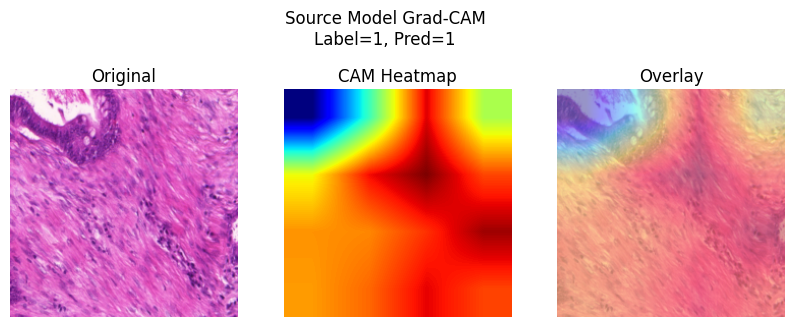

SFDA-DE


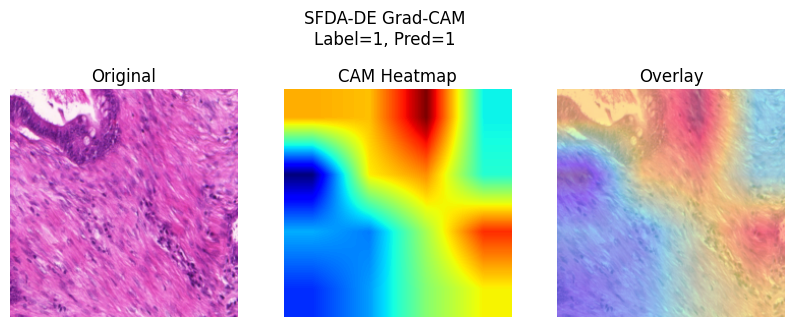

SHOT


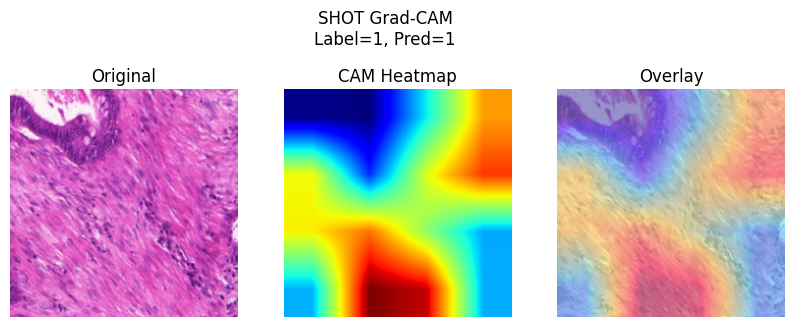

CDCL


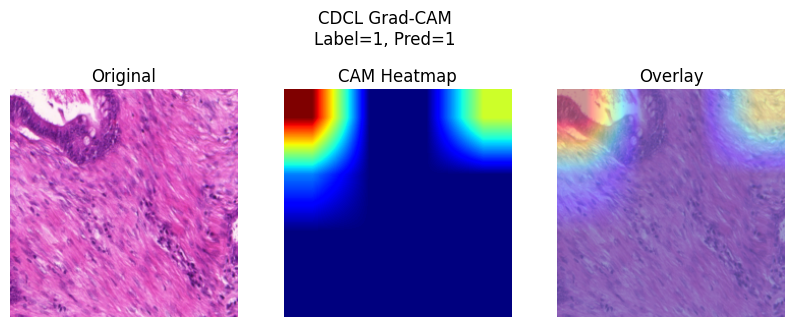

AdaDSA


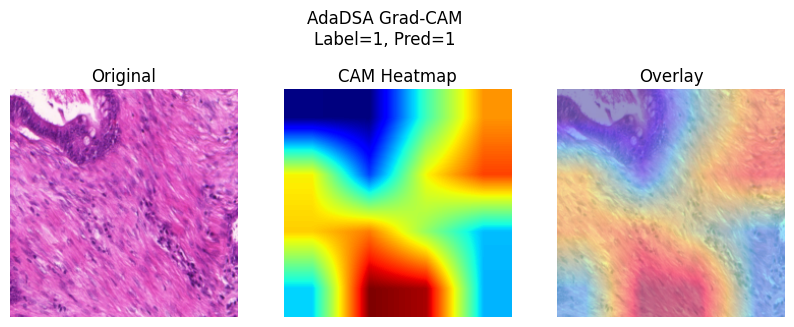

In [28]:
import os
import csv
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

###############################################################################
# 1) DATASET: GlaS Classification
###############################################################################
def parse_grade_csv(csv_path):
    """
    Reads 'Grade.csv' with columns (name, grade), 
    where grade is 'benign' or 'malignant'.
    Returns dict {basename -> label(0/1)}.
    """
    name_to_label = {}
    with open(csv_path, 'r', newline='') as f:
        reader = csv.DictReader(f)
        for row in reader:
            base_name = row['name']
            grade_str = row['grade'].lower().strip()
            label = 0 if grade_str == 'benign' else 1
            name_to_label[base_name] = label
    return name_to_label

class GlaSClassificationDataset(Dataset):
    """
    Minimal classification dataset for GlaS. 
    Ignores masks, focusing on images + Grade.csv.
    """
    def __init__(self, image_dir, grade_dict, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.samples = []
        for fname in os.listdir(image_dir):
            base, _ = os.path.splitext(fname)
            if base in grade_dict:
                self.samples.append(fname)
        self.grade_dict = grade_dict

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        fname = self.samples[idx]
        base, _ = os.path.splitext(fname)
        img_path = os.path.join(self.image_dir, fname)
        image = Image.open(img_path).convert('RGB')
        label = self.grade_dict[base]
        if self.transform:
            image = self.transform(image)
        return image, label, base


###############################################################################
# 2) SIMPLE CNN MODEL
###############################################################################
class SimpleNet(nn.Module):
    """
    A minimal CNN with a (features, classifier) structure.
    """
    def __init__(self, num_classes=2):
        super(SimpleNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((4,4))
        )
        self.classifier = nn.Linear(32*4*4, num_classes)

    def forward(self, x):
        feat = self.features(x)          # shape: B x 32 x 4 x 4
        flatten = feat.view(feat.size(0), -1)
        logits = self.classifier(flatten)
        return logits, feat


###############################################################################
# 3) SFDA METHODS
###############################################################################

###############################
# (A) SFDA-DE (Two-Pass Approach)
###############################
class SFDADE(nn.Module):
    """
    1) PASS A (Offline): gather features for entire dataset, do spherical k-means => means,covs
    2) PASS B (Online): For each mini-batch, compute MMD-like discrepancy => backprop.
    """
    def __init__(self, feature_extractor, classifier, num_classes=2, gamma=1.0, lr=1e-4, epochs=5):
        super().__init__()
        self.feature_extractor = feature_extractor
        self.classifier = classifier
        self.num_classes = num_classes
        self.gamma = gamma
        self.epochs = epochs

        params = list(self.feature_extractor.parameters()) + list(self.classifier.parameters())
        self.optimizer = optim.Adam(params, lr=lr)

        self.means = None  # will store offline
        self.covs  = None

    def forward(self, x):
        feats = self.feature_extractor(x)
        if feats.ndim > 2:
            feats = feats.view(feats.size(0), -1)
        logits = self.classifier(feats)
        return logits, feats

    def adapt(self, loader, device):
        self.to(device)
        for ep in range(self.epochs):
            # PASS A: offline
            self._build_stats(loader, device)

            # PASS B: online
            train_loss = self._pass_b(loader, device)

            print(f"[SFDA-DE] Epoch {ep+1}/{self.epochs}, Loss={train_loss:.4f}")

    def _build_stats(self, loader, device):
        """
        1) Collect features (no grad)
        2) Spherical k-means => pseudo-labels
        3) Estimate means/covs => store in self.means, self.covs
        """
        self.eval()
        all_feats = []
        with torch.no_grad():
            for imgs, _, _ in loader:
                imgs = imgs.to(device)
                # Just get the features from feature_extractor
                feats = self.feature_extractor(imgs)
                if feats.ndim > 2:
                    feats = feats.view(feats.size(0), -1)
                feats = F.normalize(feats, dim=1)
                all_feats.append(feats)
        all_feats = torch.cat(all_feats, dim=0)  # shape: N x D

        # spherical k-means
        pseudo = self._spherical_kmeans(all_feats, self.num_classes)
        # compute means, covs
        means, covs = [], []
        for k in range(self.num_classes):
            subset = all_feats[pseudo == k]
            if subset.size(0) == 0:
                d = all_feats.size(1)
                mu = torch.zeros(d, device=device)
                cv = torch.eye(d, device=device)
            else:
                mu = subset.mean(dim=0)
                diff = subset - mu
                cv = (diff.T @ diff)/ subset.size(0)
                cv = cv + self.gamma*torch.eye(diff.size(1), device=device)
            means.append(mu)
            covs.append(cv)
        self.means = torch.stack(means, dim=0)
        self.covs  = torch.stack(covs,  dim=0)

    def _pass_b(self, loader, device):
        """
        For each batch:
         - Forward pass with grad
         - For each sample, measure MMD to the distribution => sum up
         - Backprop
        """
        self.train()
        running_loss = 0.0
        total_samples = 0
        for imgs, _, _ in loader:
            imgs = imgs.to(device)
            logits, feats = self.forward(imgs)
            feats_norm = F.normalize(feats, dim=1)

            with torch.no_grad():
                sim = feats_norm @ F.normalize(self.means, dim=1).T  # B x K
                pseudo = sim.argmax(dim=1)

            cdd_loss = torch.tensor(0.0, device=device, requires_grad=True)
            for i in range(imgs.size(0)):
                c = pseudo[i]
                diff_mean = (feats[i] - self.means[c]).pow(2).sum()
                diff_cov  = self.covs[c].trace()  # placeholder
                cdd_loss  = cdd_loss + (diff_mean + diff_cov)
            cdd_loss = cdd_loss / imgs.size(0)

            self.optimizer.zero_grad()
            cdd_loss.backward()
            self.optimizer.step()

            running_loss  += cdd_loss.item() * imgs.size(0)
            total_samples += imgs.size(0)

        return running_loss / (total_samples + 1e-8)

    def _spherical_kmeans(self, feats, k=2, iters=5):
        """
        feats: (N, D)
        returns labels: (N,)
        """
        centroids = feats[torch.randperm(len(feats))[:k]].clone()
        for _ in range(iters):
            sim = feats @ centroids.T
            labels = sim.argmax(dim=1)
            for i in range(k):
                idxs = (labels == i)
                if idxs.sum() > 0:
                    centroids[i] = feats[idxs].mean(dim=0)
        return labels


###############################
# (B) SHOT
###############################
class SHOT(nn.Module):
    def __init__(self, feature_extractor, classifier, num_classes=2, lr=1e-3, momentum=0.9, epochs=5):
        super().__init__()
        self.feature_extractor = feature_extractor
        self.classifier = classifier
        self.num_classes = num_classes
        self.epochs = epochs
        params = list(self.feature_extractor.parameters()) + list(self.classifier.parameters())
        self.optimizer = optim.SGD(params, lr=lr, momentum=momentum)

    def forward(self, x):
        feats = self.feature_extractor(x)
        feats = feats.view(feats.size(0), -1)
        logits = self.classifier(feats)
        return logits, feats

    def adapt(self, loader, device):
        self.to(device)
        for ep in range(self.epochs):
            with torch.no_grad():
                sum_probs = torch.zeros(self.num_classes, device=device)
                total_count = 0
                for imgs, _, _ in loader:
                    imgs = imgs.to(device)
                    logits, _ = self.forward(imgs)
                    probs = F.softmax(logits, dim=1)
                    sum_probs += probs.sum(dim=0)
                    total_count += probs.size(0)
            p_hat = sum_probs / (total_count+1e-8)
            p_hat = torch.clamp(p_hat, min=1e-8, max=1.0)

            running_loss = 0.0
            total_samples= 0
            self.train()
            for imgs, _, _ in loader:
                imgs = imgs.to(device)
                logits, _ = self.forward(imgs)
                probs = F.softmax(logits, dim=1)
                log_probs = F.log_softmax(logits, dim=1)
                ent_loss = - (probs*log_probs).sum(dim=1).mean()
                div_loss = (p_hat*torch.log(p_hat)).sum()
                total_loss= ent_loss + div_loss

                self.optimizer.zero_grad()
                total_loss.backward()
                self.optimizer.step()

                running_loss += total_loss.item() * imgs.size(0)
                total_samples += imgs.size(0)

            avg_loss = running_loss/(total_samples+1e-8)
            print(f"[SHOT] Epoch {ep+1}/{self.epochs}, Loss={avg_loss:.4f}")

###############################
# (C) CDCL
###############################
class CDCL(nn.Module):
    def __init__(self, feature_extractor, source_classifier_weights, num_classes=2, temperature=0.07, lr=1e-4, epochs=5):
        super().__init__()
        self.feature_extractor = feature_extractor
        self.register_buffer('source_weights', source_classifier_weights.clone())
        self.num_classes = num_classes
        self.temperature = temperature
        self.epochs = epochs
        self.optimizer = optim.Adam(self.feature_extractor.parameters(), lr=lr)

    def forward(self, x):
        feats = self.feature_extractor(x)
        feats = feats.view(feats.size(0), -1)
        return feats

    def adapt(self, loader, device):
        self.to(device)
        for ep in range(self.epochs):
            all_feats = []
            with torch.no_grad():
                for imgs, _, _ in loader:
                    imgs = imgs.to(device)
                    feats = self.forward(imgs)
                    feats = F.normalize(feats, dim=1)
                    all_feats.append(feats)
            all_feats = torch.cat(all_feats, dim=0)
            pseudo = self._spherical_kmeans(all_feats, k=self.num_classes)

            idx_offset=0
            running_loss=0.0
            total_samples=0
            for imgs, _, _ in loader:
                bs=imgs.size(0)
                idxs=range(idx_offset, idx_offset+bs)
                pseudo_batch = pseudo[list(idxs)]
                idx_offset += bs

                imgs=imgs.to(device)
                feats=self.forward(imgs)
                logits=self._compute_logits(feats)
                loss_ce = F.cross_entropy(logits, pseudo_batch.to(device))

                self.optimizer.zero_grad()
                loss_ce.backward()
                self.optimizer.step()

                running_loss+=loss_ce.item()*bs
                total_samples+=bs
            avg_loss=running_loss/(total_samples+1e-8)
            print(f"[CDCL] Epoch {ep+1}/{self.epochs}, Loss={avg_loss:.4f}")

    def _compute_logits(self, feats):
        w_s = self.source_weights
        logits = feats @ w_s.T / self.temperature
        return logits

    def _spherical_kmeans(self, feats, k=2, iters=5):
        N,D=feats.size()
        centroids=feats[torch.randperm(N)[:k]]
        for _ in range(iters):
            sim=feats@centroids.T
            labels=sim.argmax(dim=1)
            for i in range(k):
                cfeats=feats[labels==i]
                if cfeats.size(0)>0:
                    centroids[i]=cfeats.mean(dim=0)
        return labels

###############################
# (D) AdaDSA
###############################
class AdaDSA(nn.Module):
    def __init__(self, target_model, source_model, alpha=0.5, lambda_=0.5, lr=1e-4, epochs=5):
        super().__init__()
        self.target_model = target_model
        self.source_model = source_model
        self.alpha = alpha
        self.lambda_ = lambda_
        self.epochs = epochs

        self.source_model.eval()
        params = list(self.target_model.parameters())
        self.optimizer = optim.Adam(params, lr=lr)

        self.src_bns=[]
        for m in self.source_model.modules():
            if isinstance(m, nn.BatchNorm2d):
                self.src_bns.append({
                    'running_mean': m.running_mean.detach().clone(),
                    'running_var':  m.running_var.detach().clone()
                })
        self.tgt_bns=[]
        for m in self.target_model.modules():
            if isinstance(m, nn.BatchNorm2d):
                self.tgt_bns.append(m)

    def forward(self, x):
        return self.target_model(x)

    def adapt(self, loader, device):
        self.to(device)
        self.source_model.eval()
        self.target_model.train()
        for ep in range(self.epochs):
            self._update_bn_stats()
            running_loss=0.0
            total_samples=0
            for imgs, _, _ in loader:
                imgs=imgs.to(device)
                with torch.no_grad():
                    src_logits,_=self.source_model(imgs)
                    src_probs=F.softmax(src_logits,dim=1)
                tgt_logits,_=self.target_model(imgs)
                tgt_probs=F.softmax(tgt_logits,dim=1)

                blend_probs=(1-self.lambda_)*src_probs + self.lambda_*tgt_probs
                refined_labels=blend_probs.argmax(dim=1)

                logits,_=self.target_model(imgs)
                loss_ce=F.cross_entropy(logits, refined_labels)

                self.optimizer.zero_grad()
                loss_ce.backward()
                self.optimizer.step()

                running_loss+=loss_ce.item()*imgs.size(0)
                total_samples+=imgs.size(0)
            avg_loss=running_loss/(total_samples+1e-8)
            print(f"[AdaDSA] Epoch {ep+1}/{self.epochs}, Loss={avg_loss:.4f}")

    def _update_bn_stats(self):
        for (m_tgt, data_src) in zip(self.tgt_bns, self.src_bns):
            mu_t = m_tgt.running_mean.detach()
            var_t= m_tgt.running_var.detach()
            mu_s = data_src['running_mean']
            var_s= data_src['running_var']

            mu_ts= self.alpha*mu_t+(1-self.alpha)*mu_s
            var_ts=self.alpha*(var_t+(mu_t-mu_ts)**2)+(1-self.alpha)*(var_s+(mu_s-mu_ts)**2)

            m_tgt.running_mean.copy_(mu_ts)
            m_tgt.running_var.copy_(var_ts)


###############################################################################
# 4) GRAD-CAM
###############################################################################
class GradCAM:
    def __init__(self, model):
        self.model=model
        self.gradients=None
        self.activations=None
        def forward_hook(m,i,o):
            self.activations=o
        def backward_hook(m,gi,go):
            self.gradients=go[0]
        self.model.features.register_forward_hook(forward_hook)
        self.model.features.register_backward_hook(backward_hook)

    def __call__(self,x,class_idx=None):
        self.model.zero_grad()
        logits, feat=self.model(x)
        if class_idx is None:
            class_idx=logits.argmax(dim=1)
        one_hot=torch.zeros_like(logits)
        for i in range(logits.size(0)):
            one_hot[i,class_idx[i]]=1.0
        logits.backward(gradient=one_hot,retain_graph=True)
        grads=self.gradients
        acts=self.activations
        alpha=grads.view(grads.size(0),grads.size(1),-1).mean(dim=2)
        cams=[]
        for i in range(acts.size(0)):
            w_acts=alpha[i].unsqueeze(-1).unsqueeze(-1)*acts[i]
            cam=w_acts.sum(dim=0)
            cam=F.relu(cam)
            mi,ma=cam.min(),cam.max()
            cam=(cam-mi)/(ma-mi+1e-8)
            cams.append(cam)
        cams=torch.stack(cams,dim=0)
        return logits,cams

def visualize_gradcam(model, loader, device, title_prefix="Model"):
    gradcam=GradCAM(model)
    model.eval()
    images,labels,_=next(iter(loader))
    images=images.to(device)
    labels=labels.to(device)

    with torch.no_grad():
        logits,_=model(images)
        preds=logits.argmax(dim=1)

    logits,cams=gradcam(images)
    cam0=cams[0].cpu().detach().numpy()

    import torch.nn.functional as F2
    cam0_up=F2.interpolate(
        torch.tensor(cam0).unsqueeze(0).unsqueeze(0),
        size=(224,224),mode='bilinear',align_corners=False
    ).squeeze().numpy()

    img0=images[0].cpu().detach().numpy().transpose(1,2,0)
    img0=np.clip(img0,0,1)

    plt.figure(figsize=(10,4))
    plt.suptitle(f"{title_prefix} Grad-CAM\nLabel={labels[0].item()}, Pred={preds[0].item()}")
    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(img0)
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.title("CAM Heatmap")
    plt.imshow(cam0_up,cmap='jet')
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.title("Overlay")
    plt.imshow(img0,alpha=0.6)
    plt.imshow(cam0_up,cmap='jet',alpha=0.4)
    plt.axis('off')
    plt.show()


###############################################################################
# 5) MAIN
###############################################################################
def main():
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Directory structure
    glas_root="../data/GlaS"
    csv_path =os.path.join(glas_root,"Grade.csv")
    train_dir=os.path.join(glas_root,"train","images")
    test_dir =os.path.join(glas_root,"test","images")

    # Parse CSV
    grade_dict=parse_grade_csv(csv_path)

    # Datasets
    transform=T.Compose([
        T.Resize((224,224)),
        T.ToTensor()
    ])
    train_ds=GlaSClassificationDataset(train_dir,grade_dict,transform=transform)
    test_ds =GlaSClassificationDataset(test_dir, grade_dict,transform=transform)
    train_loader=DataLoader(train_ds,batch_size=8,shuffle=True)
    test_loader =DataLoader(test_ds,batch_size=8,shuffle=False)

    # Source model
    src_path="./models/source_model.pth"
    source_model=SimpleNet(num_classes=2).to(device)
    if not os.path.exists(src_path):
        print("Training source model from scratch on GlaS train set...")
        opt=optim.Adam(source_model.parameters(),lr=1e-3)
        crit=nn.CrossEntropyLoss()
        for ep in range(100):
            correct,total,running_loss=0,0,0.0
            source_model.train()
            for imgs,labels,_ in train_loader:
                imgs,labels=imgs.to(device),labels.to(device)
                opt.zero_grad()
                logits,_=source_model(imgs)
                loss=crit(logits,labels)
                loss.backward()
                opt.step()
                running_loss+=loss.item()*imgs.size(0)
                correct+=(logits.argmax(dim=1)==labels).sum().item()
                total+=imgs.size(0)
            print(f"Ep {ep+1}/5, Loss={running_loss/total:.4f}, Acc={100.0*correct/total:.2f}%")
        torch.save(source_model.state_dict(),src_path)
    else:
        source_model.load_state_dict(torch.load(src_path))

    # Evaluate source
    source_model.eval()
    correct,total=0,0
    with torch.no_grad():
        for imgs,labels,_ in test_loader:
            imgs,labels=imgs.to(device),labels.to(device)
            logits,_=source_model(imgs)
            preds=logits.argmax(dim=1)
            correct+=(preds==labels).sum().item()
            total+=labels.size(0)
    print(f"[Source] Test Accuracy: {100.0*correct/total:.2f}%")

    # Helper: freeze classifier
    def freeze_classifier(net):
        for p in net.classifier.parameters():
            p.requires_grad=False

    # =============== SFDA-DE =================
    tgt_sfdade=SimpleNet(num_classes=2).to(device)
    tgt_sfdade.load_state_dict(source_model.state_dict())
    freeze_classifier(tgt_sfdade)
    sfdade=SFDADE(tgt_sfdade.features,tgt_sfdade.classifier, num_classes=2,gamma=1.0,lr=1e-4,epochs=100)

    # =============== SHOT ====================
    tgt_shot=SimpleNet(num_classes=2).to(device)
    tgt_shot.load_state_dict(source_model.state_dict())
    freeze_classifier(tgt_shot)
    shot=SHOT(tgt_shot.features,tgt_shot.classifier,num_classes=2,lr=1e-3,momentum=0.9,epochs=100)

    # =============== CDCL ====================
    tgt_cdcl=SimpleNet(num_classes=2).to(device)
    tgt_cdcl.load_state_dict(source_model.state_dict())
    freeze_classifier(tgt_cdcl)
    with torch.no_grad():
        src_weights=source_model.classifier.weight.clone()
    cdcl=CDCL(tgt_cdcl.features,src_weights,num_classes=2,temperature=0.07,lr=1e-4,epochs=100)

    # =============== AdaDSA ==================
    tgt_adadsa=SimpleNet(num_classes=2).to(device)
    tgt_adadsa.load_state_dict(source_model.state_dict())
    adadsa=AdaDSA(tgt_adadsa, source_model, alpha=0.5,lambda_=0.5,lr=1e-4,epochs=100)

    # Adapt each method
    print("\n=== SFDA-DE ===")
    sfdade.adapt(test_loader,device)

    print("\n=== SHOT ===")
    shot.adapt(test_loader,device)

    print("\n=== CDCL ===")
    cdcl.adapt(test_loader,device)

    print("\n=== AdaDSA ===")
    adadsa.adapt(test_loader,device)

    # Evaluate
    def evaluate_model(model,loader,name):
        model.eval()
        c,t=0,0
        with torch.no_grad():
            for imgs,labels,_ in loader:
                imgs,labels=imgs.to(device),labels.to(device)
                logits,_=model(imgs)
                preds=logits.argmax(dim=1)
                c+=(preds==labels).sum().item()
                t+=labels.size(0)
        acc=100.0*c/t if t>0 else 0
        print(f"[{name}] Test Accuracy: {acc:.2f}%")

    print("\n=== Final Evaluation ===")
    evaluate_model(tgt_sfdade, test_loader, "SFDA-DE")

    # For SHOT
    evaluate_model(tgt_shot, test_loader, "SHOT")

    # For CDCL, we do a custom forward:
    def cdcl_forward(model, images):
        feats=model.forward(images)
        w_s=model.source_weights
        return feats@w_s.T / model.temperature

    c,t=0,0
    tgt_cdcl.eval()
    with torch.no_grad():
        for imgs,labels,_ in test_loader:
            imgs,labels=imgs.to(device),labels.to(device)
            logits=cdcl_forward(cdcl,imgs)
            preds=logits.argmax(dim=1)
            c+=(preds==labels).sum().item()
            t+=labels.size(0)
    print(f"[CDCL] Test Accuracy: {100.0*c/t:.2f}%")

    # For AdaDSA
    evaluate_model(tgt_adadsa, test_loader, "AdaDSA")

    # Grad-CAM Visualizations
    print("\n=== Grad-CAM Visualization ===")
    def do_cam(model, loader, title):
        print(title)
        visualize_gradcam(model, loader, device, title_prefix=title)

    do_cam(source_model, test_loader, "Source Model")
    do_cam(tgt_sfdade, test_loader, "SFDA-DE")
    do_cam(tgt_shot,   test_loader, "SHOT")
    do_cam(tgt_cdcl,   test_loader, "CDCL")
    do_cam(tgt_adadsa, test_loader, "AdaDSA")


if __name__=="__main__":
    main()
